# M5A 회귀분석을 통한 매출예측 방법
- 회귀분석 기초 개념
- 모델링용 데이터 준비 과정
- 시계열 데이터의 시각화
- 회귀분석 모델 생성
- 매출예측, 외부환경변화영향 분석에 회귀분석 활용
<br><br>
- [목표] 모델링 방법 중 **가장 기본적인 개념**인 회귀분석을 활용해 매출을 예측하는 방법을 이해


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt5(arr):
    stdev = .07*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)

# 값별 인원수와 구성비를 dataframe 형태로 출력하는 함수
def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)


import warnings
warnings.filterwarnings('ignore')


# local data path
# dataPath = 'D:/YONG/myPydata/' # 위치는 사용자 지정
dataPath = 'C:/Users/kofot/fashionRetailAnalysisPy_4a-20230629T052521Z-001/fashionRetailAnalysisPy_4a/' # 생성위치는 사용자 지정

import matplotlib.font_manager
    
# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


## 데이터 불러오기

In [106]:
# 상품 테이블 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

# 판매내역 테이블 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

# 고객 테이블 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)


In [107]:
# 판매내역 테이블 보기

print(sales.shape)
sales[['date','amt']].sample(5)

(41936, 19)


,date,amt
2115,2019-02-01 11:22:21.042531,35000
10816,2019-03-06 11:28:32.029530,100000
28740,2020-12-13 11:11:53.801647,90000
6806,2019-04-12 17:43:23.622974,100000
35866,2020-05-03 17:20:18.314082,60000


## Section 1 : 전체매출의 월별 집계 - 탐색적 기초 분석
- 전체 매출의 추이 파악을 통해 매출예측을 위해 어떤 방식을 사용해야할 것인지 검토

In [108]:
# 월별 매출액 집계 ~ 2019~2020 2개년간 월별 집계

sales01 = sales[['date','amt']]
# 월까지의 항목 추출해 별도 컬럼으로
sales01['saleMon'] = sales01.date.str.slice(0,7)
display(sales01.sort_values('saleMon').head())
display(sales01.sort_values('saleMon').tail())

# \n 으로 텍스트 출력 전에 한줄 띄우기
print('\n집계된 월별 매출 확인')

sales02 = sales01[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()
display(sales02.tail())

,date,amt,saleMon
6138,2019-01-02 14:50:36.926853,100000,2019-01
1370,2019-01-21 19:02:13.719480,100000,2019-01
1369,2019-01-21 17:45:18.267615,80000,2019-01
1367,2019-01-21 18:58:16.553163,230000,2019-01
1364,2019-01-21 18:33:22.242769,70000,2019-01


,date,amt,saleMon
28605,2020-12-01 09:09:34.442499,110000,2020-12
28602,2020-12-01 10:59:51.143300,80000,2020-12
28599,2020-12-11 13:38:56.524505,35000,2020-12
28596,2020-12-11 12:54:36.772643,120000,2020-12
18103,2020-12-02 22:36:27.795051,140000,2020-12



집계된 월별 매출 확인


,saleMon,amt
19,2020-08,132261000
20,2020-09,222280000
21,2020-10,117480000
22,2020-11,256118000
23,2020-12,234235000


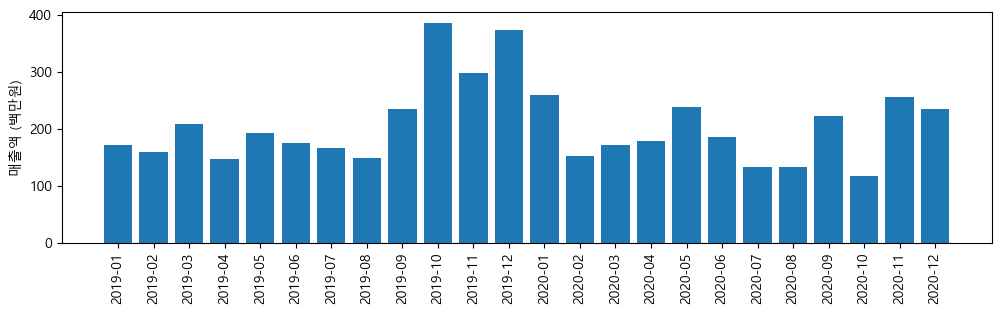

In [110]:
# 전체 매출 월별 추이 시각화 

# 챠트의 가로세로 크기를 지정
# 가로, 세로 순서로 지정
plt.figure(figsize=(12,3)) 

plt.bar(sales02.saleMon, sales02.amt/1e+6)
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)
plt.show()

- 시간의 흐름에 따라 변화가 나타나는 것 처럼 보이지만 세부적으로는 직선의 관계(추세)와 동시에 계절적인 차이 패턴도 존재하는 듯
- 2019 겨울에 매출이 컸으나 2020 겨울에는 전년에 비해 전체적으로 상당히 감소한 패턴

- **[참고]** plt.figure(figsize=(width, height)) 에서 폭과 높이의 default 는 [6.4, 4.8]

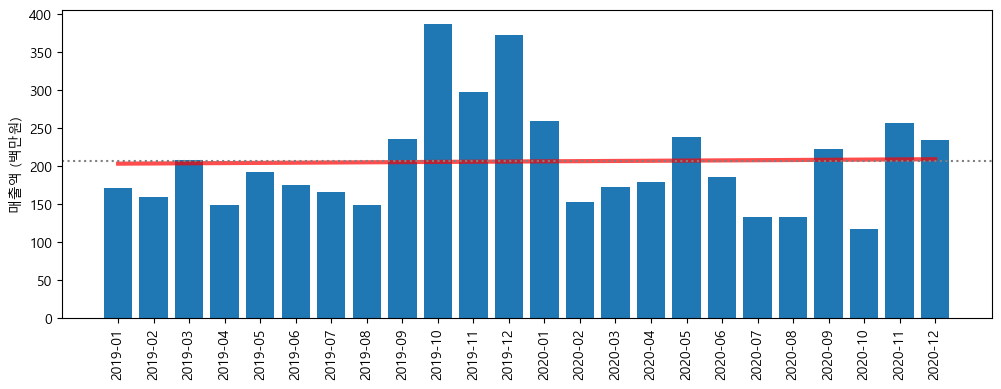

In [111]:
# 전체 매출 월별 추이 시각화 

plt.figure(figsize=(12,4)) # 챠트의 가로세로 크기를 지정
# XY 순서로 지정

plt.bar(sales02.saleMon, sales02.amt/1000000)
plt.ylabel('매출액 (백만원)')
plt.xticks(rotation=90)

# 계절성과 기타의 변동이 있다는 점을 무시하고 전체적인 추세만 본다면?
# 추세 : 각 월의 막대들의 중간을 통과하는 직선
varx = np.arange(len(sales02))
vary = sales02.amt/1e+6
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 평균선
plt.axhline(vary.mean(), color='grey', linestyle=':')
plt.show()

- **추세선**(red)과 **평균선**(dotted grey)간에 거의 차이 없음
- == 증가도 감소도 없는 추세?
<br><br>
- 매출추이를 분석하는데 필수적인 **계절 영향**을 무시했기에 발생된 결과
- 사용한 **데이터 기간이 짧은 (3년미만)** 영향도 

### 상품군별 매출 추이 비교

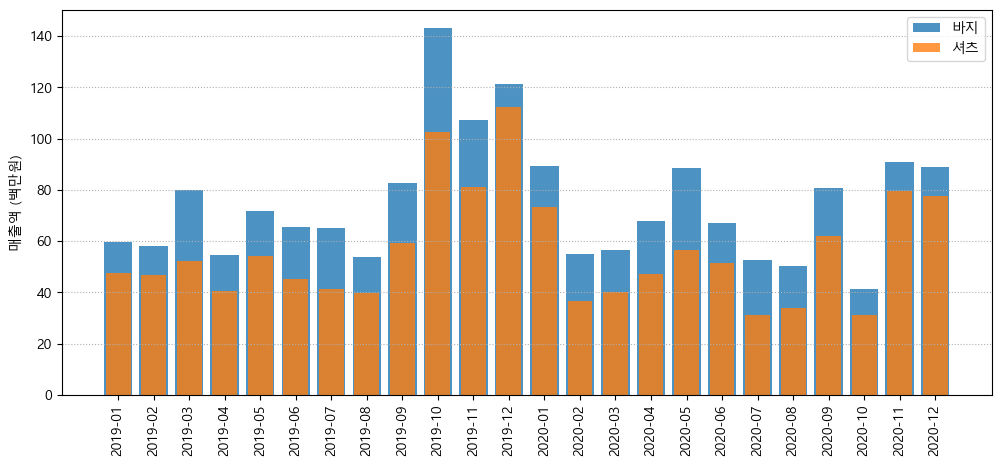

In [117]:
# 바지와 셔츠 두 가지 상품군의 매출 월별 추이 비교 시각화 

# 각각의 매출 집계 계산
sales01a = sales[sales.scat=='바지'][['date','amt']]
sales01a['saleMon'] = sales01a.date.str.slice(0,7)
sales02a = sales01a[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

sales01b = sales[sales.scat=='셔츠'][['date','amt']]
sales01b['saleMon'] = sales01b.date.str.slice(0,7)
sales02b = sales01b[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

# 바지와 셔츠 매출 월별 추이 비교 시각화 

plt.figure(figsize=(12,5))
# 바지
plt.bar(sales02a.saleMon, sales02a.amt/1e+6, alpha=0.8)
# 셔츠
plt.bar(sales02b.saleMon, sales02b.amt/1e+6, alpha=0.8, width=0.7)
plt.ylabel('매출액 (백만원)')
plt.legend(['바지','셔츠'])
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle=':') # 가로줄만 보조선 추가
# plt.grid(axis='x', linestyle=':')
plt.show()

- **분석결과에 대한 검토**: 상품군과 무관하게 유사한 계절성과 추세?

### 실무에서 흔히 사용하는 분석 방식 - 전년동기대비 변화 검토

,saleMon,amt,yr,mon
7,2019-08,39918000,2019,08
2,2019-03,52160000,2019,03
14,2020-03,39980000,2020,03
12,2020-01,73125000,2020,01
17,2020-06,51355000,2020,06


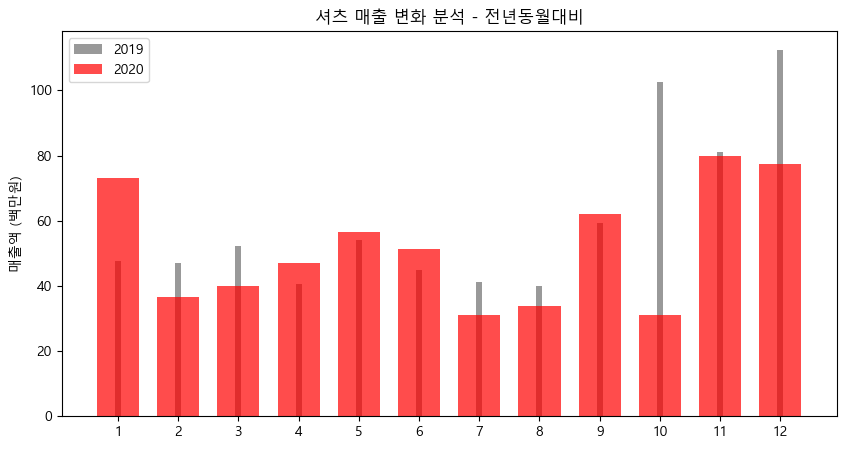

In [118]:
# 위에서 생성한 셔츠 월별 매출 집계를 활용
sales02b1 = sales01b[['saleMon', 'amt']].groupby('saleMon').sum().reset_index()

# 연도를 구별하는 컬럼 추가
sales02b1['yr'] = np.sort(np.repeat([2019,2020], 12))

# 월을 구별하는 컬럼 추가
sales02b1['mon'] = sales02b1.saleMon.str.slice(5,7)
display(sales02b1.sample(5))

# 1차년도 테이블 분리
# reset_index(drop=True) 인덱스를 0부터 새로 부여
tmpShirtSaless1 = sales02b1.head(12).reset_index(drop=True)
# 2차년도 테이블 분리
tmpShirtSaless2 = sales02b1.tail(12).reset_index(drop=True)

plt.figure(figsize=(10,5))
# label을 겹쳐질 챠트 각각에 명확하게 지정
plt.bar(tmpShirtSaless1.mon.astype(int).astype(str), tmpShirtSaless1.amt/1e+6, alpha=0.8, width=0.1, color='grey', label='2019')
plt.bar(tmpShirtSaless2.mon.astype(int).astype(str), tmpShirtSaless2.amt/1e+6, alpha=0.7, width=0.7, color='red', label='2020')
plt.ylabel('매출액 (백만원)')

# 월만 표시하므로 xticks 회전 불필요 -- 길지 않기 때문
# plt.xticks(rotation=90)
plt.title('셔츠 매출 변화 분석 - 전년동월대비')

# 레전드 범례 표시는 이미 지정된 각 챠트의 label을 사용
plt.legend()
plt.show()

In [119]:
# 피보팅으로 처음부터 연도별 월의 두 개 컬럼으로 생성

dfsaleShirts = sales02b1.pivot(index='mon', columns='yr', values='amt').reset_index()
dfsaleShirts

yr,mon,2019,2020
0,01,47725000,73125000
1,02,46935000,36751000
2,03,52160000,39980000
3,04,40485000,47175000
4,05,54019000,56482000
5,06,45010000,51355000
6,07,41290000,30980000
7,08,39918000,33990000
8,09,59400000,62045000
9,10,102585000,30960000


In [120]:
# 전년동기대비 증가율 (YoY Year over Year %) 지수 생성

dfsaleShirts['yoy'] = round((dfsaleShirts[2020]-dfsaleShirts[2019])/dfsaleShirts[2019]*100,1)
dfsaleShirts

yr,mon,2019,2020,yoy
0,01,47725000,73125000,53.2
1,02,46935000,36751000,-21.7
2,03,52160000,39980000,-23.4
3,04,40485000,47175000,16.5
4,05,54019000,56482000,4.6
5,06,45010000,51355000,14.1
6,07,41290000,30980000,-25.0
7,08,39918000,33990000,-14.9
8,09,59400000,62045000,4.5
9,10,102585000,30960000,-69.8


In [121]:
# 2019, 2022 연도별 합계 비교

dfsaleShirts[2019].sum(), dfsaleShirts[2020].sum(), dfsaleShirts[2020].sum() / dfsaleShirts[2019].sum()

(723124000, 620023000, 0.8574227933245198)

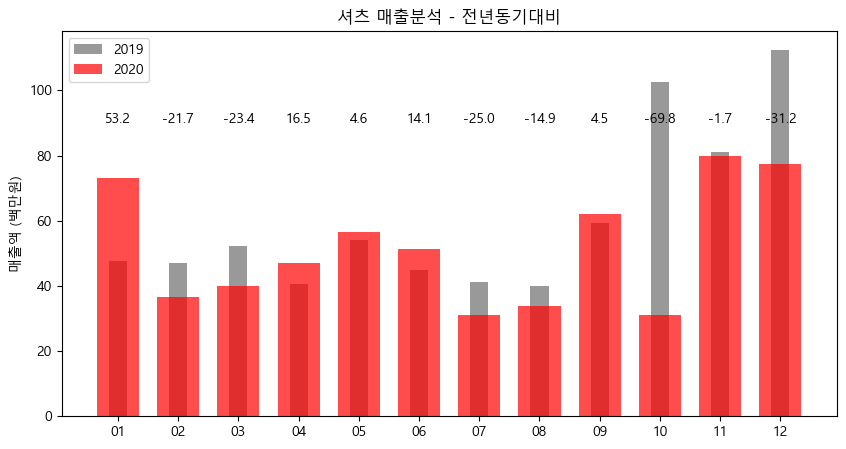

In [122]:
plt.figure(figsize=(10,5))
# 1차년도를 먼저 표시
plt.bar(tmpShirtSaless1.mon, tmpShirtSaless1.amt/1e+6, alpha=0.8, width=0.3, color='grey')
# 2차년도를 표시
plt.bar(tmpShirtSaless2.mon, tmpShirtSaless2.amt/1e+6, alpha=0.7, width=0.7, color='red')
# 2차년도(최근)가 중요하므로 강조 -- red

plt.ylabel('매출액 (백만원)')
plt.title('셔츠 매출분석 - 전년동기대비')
plt.legend([2019,2020])

# 증가 지표 표시
for i in dfsaleShirts.index:
    plt.text(tmpShirtSaless1.mon[i], 90, dfsaleShirts.yoy[i], ha='center')
plt.show()

**[전년동기대비 분석의 함정]**
- 전년이 특수한 상황이었을 경우나 전년 중 일부만 특수한 상황이었을 경우 등에서 비교가 무의미함
- 전년동기대비는 기간이 짧다는 점에서 특히 많은 문제점 내포 - 딱 두개 시점만 가지고 비교
- (**무의미한 비교**를 통한 결과 또는 **잘못된 해석**을 설득하려는 방향으로 분석이 왜곡되는 함정에 빠지지 않도록 주의 필요)

## Section 2 : 회귀분석 

## 회귀분석 기본개념

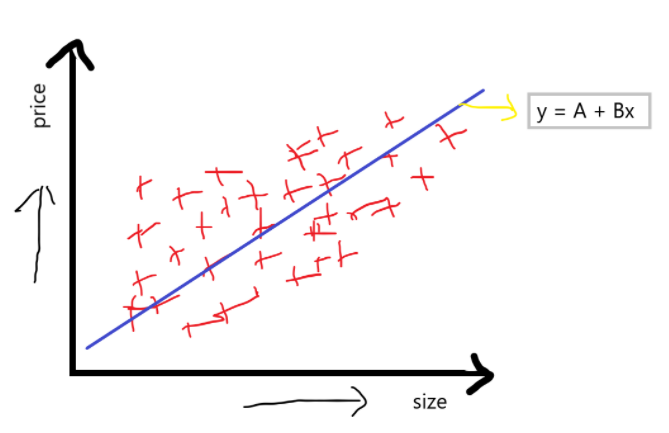

- 한 변수 값의 변화에 따라 다른 변수 값이 어떻게 달라지는 관계가 있는가를 나타내는 모델
- 독립변수(size: X)와 종속변수(price: Y)간의 관계를 선형(linear) 관계로 파악
- X와 Y 모두 숫자 형식이어야함 (numeric 즉, int 또는 float)
<br><br>
- 단순선형회귀분석 (simple linear regression) 에서는 한 개의 X 변수만을 고려

### 간단한 회귀분석 예 - 연령과 소득의 관계

In [123]:
# 고객의 연령과 소득 간의 관계를 분석

# custmast 데이터에서 연령과와 추정소득 두 컬럼만 추출
dfctmpa1 = custmast[['age', 'hh_income']]
print(dfctmpa1.shape)
dfctmpa1.sample(5)

# hh_income은 고객별 가구합산소득에 대한 추정치라고 가정
# 일부고객에 대해 표본조사한 후 결과를 전체 고객에게 적용하는 추정 estimation 모델링을
# 적용해서 얻었을 수 있음

(26000, 2)


,age,hh_income
12350,25,86000
24989,29,40000
147,30,49000
486,30,60000
20536,52,53000


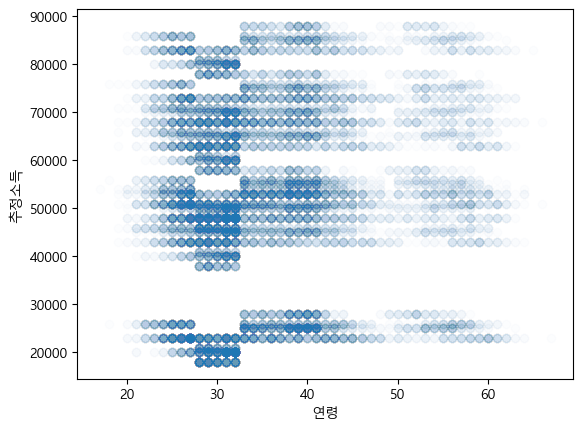

In [124]:
# 산점도를 활용한 분포 확인

plt.scatter(dfctmpa1.age, dfctmpa1.hh_income, alpha=0.01)
plt.xlabel('연령')
plt.ylabel('추정소득')
plt.show()

# 30세 전후에 가구합산소득은 낮은 패턴 -- 결혼이나 취업등으로 가구분리 독립하는 영향?

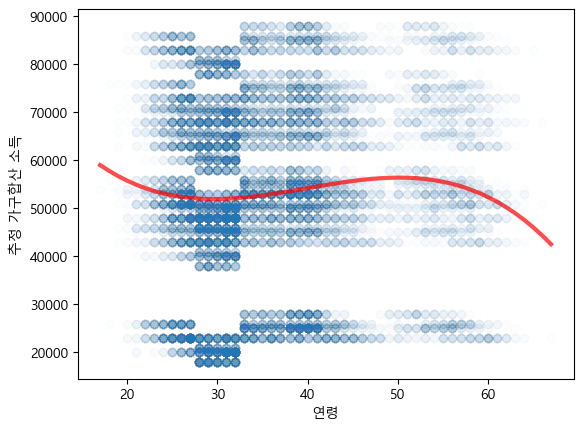

In [132]:
# 산점도에 회귀분석을 통한 회귀선 추가

plt.scatter(dfctmpa1.age, dfctmpa1.hh_income, alpha=0.01)
plt.xlabel('연령')
plt.ylabel('추정 가구합산 소득')

varx = dfctmpa1.age
vary = dfctmpa1.hh_income

# 선형회귀선 추가
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.show()

# 선형적인 관계만 보면 연령이 많을수록 가구합산소득이 좀 더 많은 관계

[해석시 주의 필요 사항] 
- 일반적으로 가구 구성원의 연령이 많아질수록 가구합산 소득이 증가할까? 연령대별로 가구구성원의 수에도 차이가 있지는 않을까? 
- 가구전체 소득의 합산 수치 뿐 아니라 구성원수가 있어야 유용하지는 않을까?
- 분석결과가 일반적인 특성인가 아니면 당사의 특수한 패턴인가?

## 매출추세에 대한 회귀분석

,saleMon,amt
19,2020-08,132261000
20,2020-09,222280000
21,2020-10,117480000
22,2020-11,256118000
23,2020-12,234235000


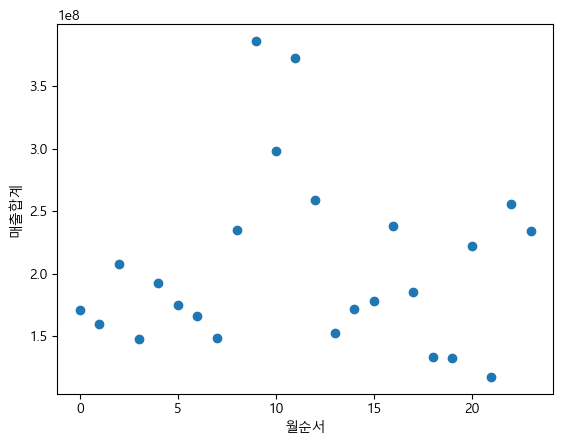

In [133]:
# 시간순서를 X축으로 삼아 회귀분석 ==> 추세를 예측하는데 사용할 수 있는 모델?

# 전체 매출 데이터 sales02
display(sales02.tail())

# 월은 숫자가 아니므로 순서 일련번호를 X로 사용
plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서') # X 독립변수 independent variable
plt.ylabel('매출합계') # Y 종속변수 dependent variable
plt.show()

**검토사항**
- 두 변수 월순서와 매출합계 간의 관계는? (선형 관점에서)
- 점들의 중간을 통과하는 하나의 직선?

### 상관계수
- 상관계수(correlation coefficient) -- 두 변수간에 양(같은) 또는 음(반대)의 방향으로 얼마나 강한 선형적인 관계를 가지는지를 하나의 숫자로 나타냄
- 한 변수의 값이 변하면 나머지 변수의 값도 변하는 관계가 얼마나 강한가? (순서무관)

In [134]:
# numpy를 사용해 월의 일련번호와 매출간의 상관계수 구하기 

np.corrcoef(np.arange(len(sales02)), sales02.amt) # 두 개의 변수 X 두 개의 변수 = 매트릭스 (matrix 행렬 table)

array([[1.        , 0.02547664],
       [0.02547664, 1.        ]])

In [18]:
# X와 Y의 관계는 대각선의 1이 아닌 값 하나임
# 매트릭스는 대칭. 결국 한 개 값만 필요

np.corrcoef(np.arange(len(sales02)), sales02.amt)[0,1]

0.025476643394213704

- 상관관계 값이 음수이면 반대방향의 관계
- 즉, 한 쪽이 증가하면 나머지는 감소

In [19]:
# pandas를 사용한 상관계수 구하기

# 월의 일련번호와 매출 두 값들을 리스트로 변환
# 리스트를 데이터프레임으로 변환
# 행렬바꿈을 한 후 corr() 함수를 적용해 매트릭스 생성
# (데이터프레임내의 컬럼들간 관계에 대해 상관계수 구하기에 편리)

pd.DataFrame([np.arange(len(sales02)), sales02.amt]).T.corr()

,0,1
0,1.000000,0.025477
1,0.025477,1.000000


#### 상관관계 correlation 의 의미 살펴보기 

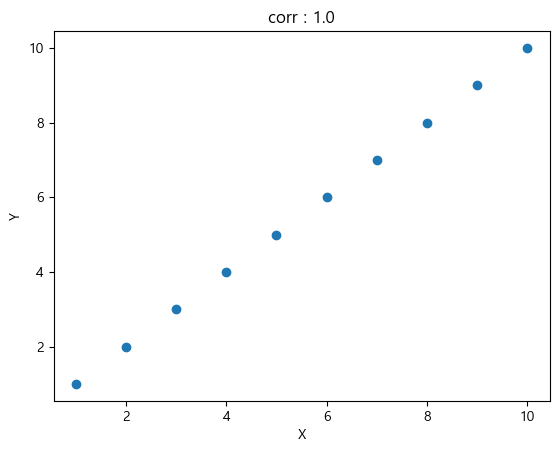

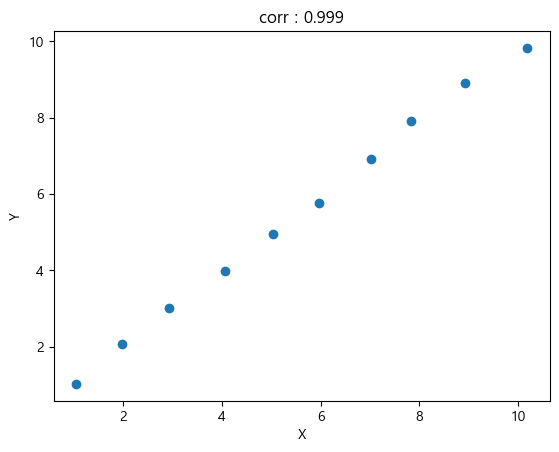

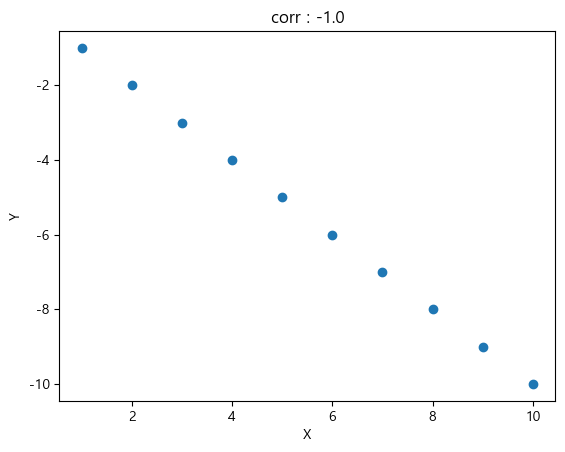

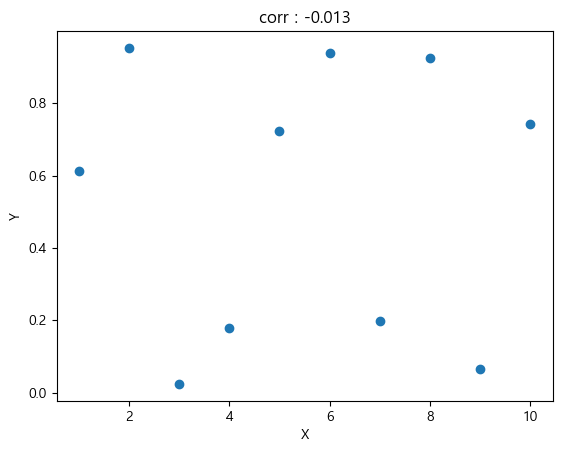

In [135]:
a = [1,2,3,4, 5, 6, 7, 8, 9, 10]

# 완전히 같은 값, 같은 방향인 경우
plt.scatter(a,a)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,a)[0,1],3))
plt.title(titleText)
plt.show()


# 거의 같은 방향인 경우
plt.scatter(rjitt(a),rjitt(a))
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(rjitt(a),rjitt(a))[0,1],3))
plt.title(titleText)
plt.show()


# 완전히 반대 방향인 경우
plt.scatter(a,-np.array(a))
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,-np.array(a))[0,1],3))
plt.title(titleText)
plt.show()


# 완전히 무관한 방향인 경우
randomNums = np.random.rand(len(a))
plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()


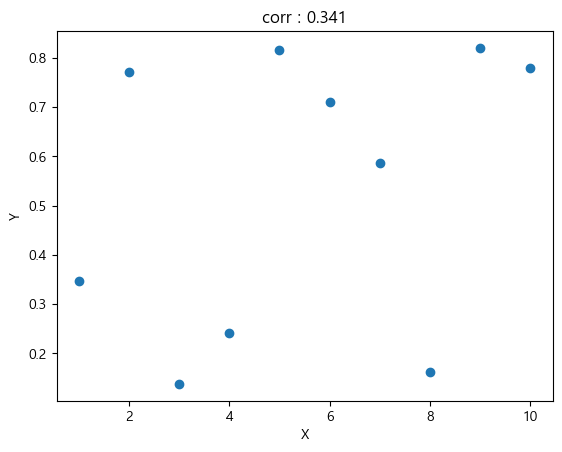

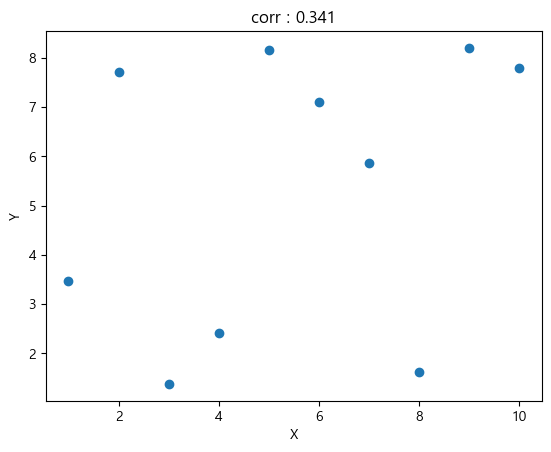

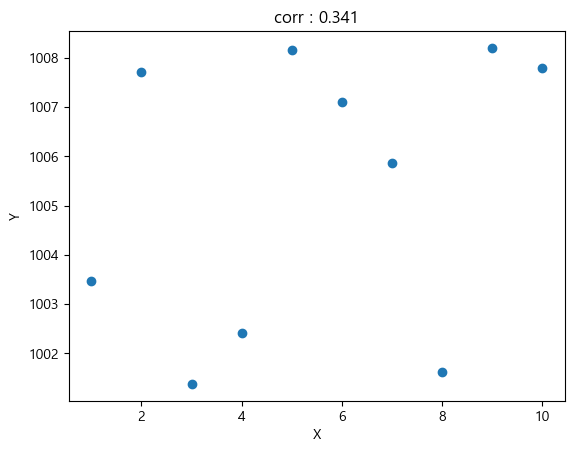

기억할 사항 :
상관계수 크기는 기울기나 절편과는 무관!


In [21]:
# 스케일만 달라진다면 상관계수가 변할까?

# 완전히 무관한 방향인 경우
randomNums = np.random.rand(len(a))
plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()

# 스케일만 달라진 경우 
randomNums = randomNums*10

plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()


# 절편이 달라진 경우 
randomNums = randomNums + 1000

plt.scatter(a,randomNums)
plt.xlabel('X')
plt.ylabel('Y')
titleText = 'corr : ' + str(round(np.corrcoef(a,randomNums)[0,1],3))
plt.title(titleText)
plt.show()

print('기억할 사항 :\n상관계수 크기는 기울기나 절편과는 무관!')

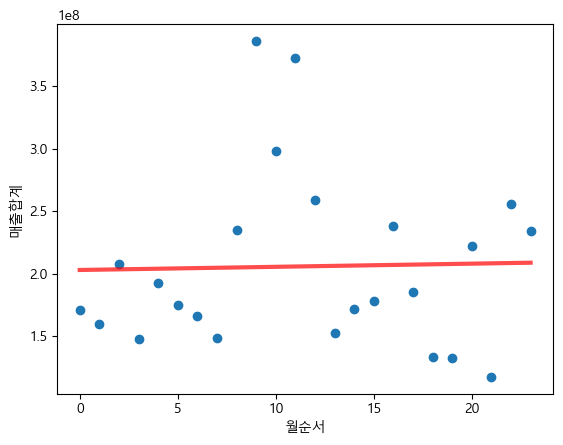

In [22]:
# 월순서와 매출합계간의 선형회귀선 (linear regression line) 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')

varx = np.arange(len(sales02))
vary = sales02.amt
# 선형회귀선
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.show()

- red 선형회귀선은 다음달로 한달이 증가할수록 매출합계가 얼마만큼씩 증가하는가를 나타내는 직선
- **선형회귀선 == '추세' (trend)**

In [136]:
# np.poly1d(선형회귀식)(대입할X값리스트)

# 회귀분석을 통해 계산한 추정 Y값은?
print(np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)))

print('\n\n')

# 다음 3개월의 Y값은?? -- 회귀분석을 통한 예측 -- 예측 대상은 24~26번째 월이므로
print(np.poly1d(np.polyfit(varx, vary, 1))(np.array([24,25,26])))

[51352.30479805 51450.27692518 51548.24905231 51646.22117945
 51744.19330658 51842.16543371 51940.13756085 52038.10968798
 52136.08181511 52234.05394225 52332.02606938 52429.99819651
 52527.97032364 52625.94245078 52723.91457791 52821.88670504
 52919.85883218 53017.83095931 53115.80308644 53213.77521358
 53311.74734071 53409.71946784 53507.69159497 53605.66372211
 53703.63584924 53801.60797637 53899.58010351 53997.55223064
 54095.52435777 54193.4964849  54291.46861204 54389.44073917
 54487.4128663  54585.38499344 54683.35712057 54781.3292477
 54879.30137484 54977.27350197 55075.2456291  55173.21775623
 55271.18988337 55369.1620105  55467.13413763 55565.10626477
 55663.0783919  55761.05051903 55859.02264617 55956.9947733
 56054.96690043 56152.93902756 56250.9111547 ]



[52038.10968798 52136.08181511 52234.05394225]


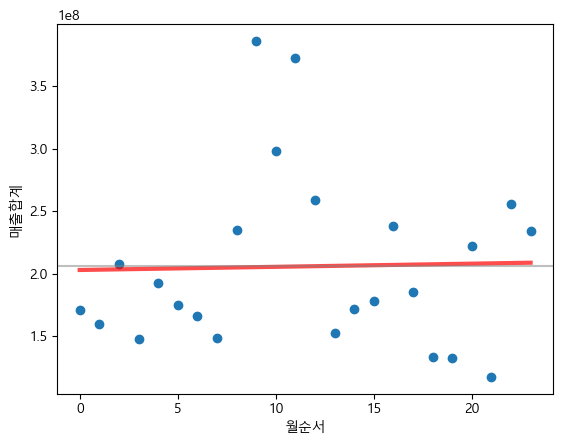

In [137]:
# 월순서와 매출합계간의 선형회귀선 (linear regression line) 

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

# 각 시점의 값에 대한 평균값 선 추가 - 회귀선과 비교용
plt.axhline(np.mean(vary), color='grey', alpha=0.5)
plt.show()

- 차이가 크지는 않지만 평균선과 추세선(회귀)이 정확히 일치하지는 않음
- 단순히 2개년간의 월별 매출액의 시간에 따른 추이를 보면 증가하는 방향처럼 보임
- 실제로는 계절(연말에 매출이 많음)의 차이에 따른 영향이 함께 반영된 결과
- (즉, 연초에서 시작해 연말로 데이터가 끝나기 때문)

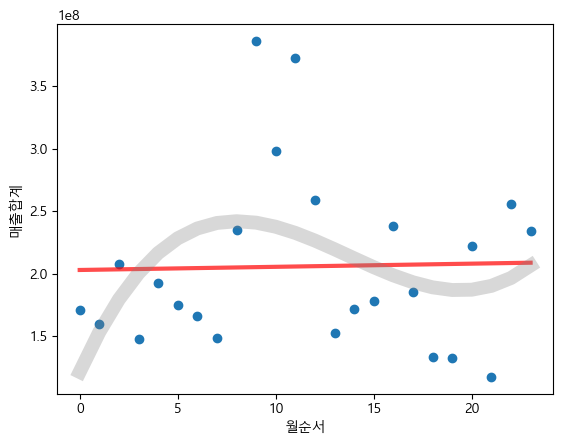

In [139]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 차수==3 
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='grey', linewidth=10, alpha=0.3)
plt.show()

- polynomial 다항식의 차수가 높을 수록 실제 월순서(X)와 매출합계(Y)간의 영역별 관계 변화를 세부적으로 표시
- 변곡점이 여러개로 나타남

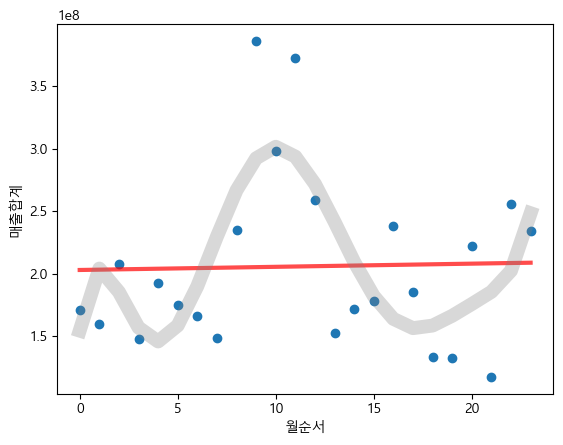

In [140]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

plt.scatter(np.arange(len(sales02)), sales02.amt)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
# 차수==7 
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 7))(np.unique(varx)), 
         color='grey', linewidth=10, alpha=0.3)
plt.show()

### Scaling 척도 변경

#### Scaling 척도 변경을 위한 사용자 정의 함수 활용

- 사용자정의함수 (user defined function UDF)는 작성자가 원하는 처리를 함수형식으로 작성해서 다른 함수들 처럼 반복해 사용
- 함수는 인수(parameter)와 반환값(return value)을 가질 수 있음

In [141]:
# 간단한 사용자 정의함수의 예 1

def sqrVal(val):
    # 입력받은 값의 제곱을 계산
    val = val**2
    return(val)

sqrVal(5)

25

In [142]:
# 간단한 사용자 정의함수의 예 2

def absDiffs(vec1, vec2):
    # 입력받은 벡터들 간의 차이의 절대값들을 계산
    vec = abs(np.array(vec1) - np.array(vec2))
    return(vec)


absDiffs([3,6,7],[2,4,12]), absDiffs([1,1,1],[2,-4,12])

(array([1, 2, 5]), array([ 1,  5, 11]))

In [143]:
# 사용자정의함수의 활용 예

# custom min max scaler
def mnmx_scl(vec):
    # 최대값과 최소값의 차이로 각 값과 최소값의 차이를 나눠
    # 상대적인 크기를 나타내도록 변경
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


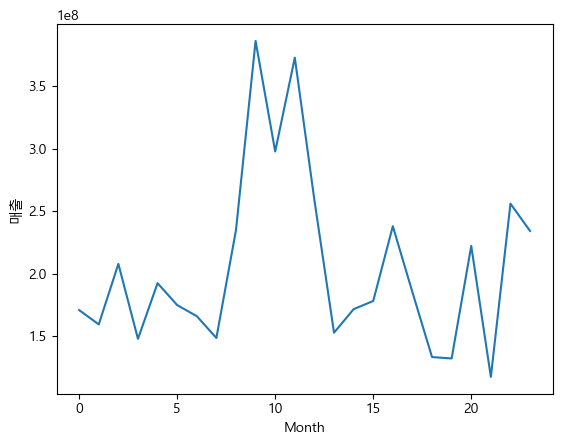

In [144]:
# 척도변환 사용자정의함수 활용 예

# 먼저 원본 값을 사용한 챠트 작성

plt.plot(sales02.amt)
plt.xlabel('Month')
plt.ylabel('매출')
plt.show()

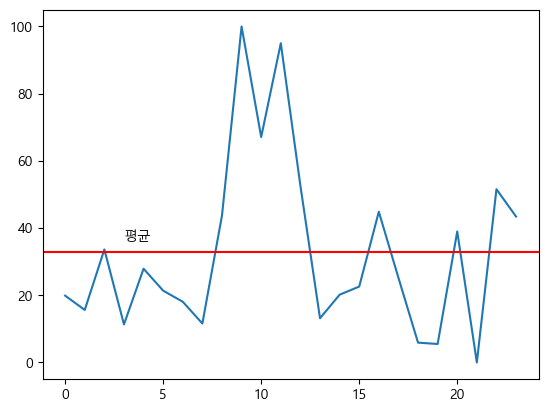

In [145]:
# 척도를 0~100 구간으로 변경 -- 사용자정의함수 활용
scaled_amt = mnmx_scl(sales02.amt) * 100

plt.plot(scaled_amt)
plt.axhline(scaled_amt.mean(), color='red')
# 평균값 보다 약간 위쪽에 선의 의미를 텍스트로 표시
plt.text(3, scaled_amt.mean()*1.1, '평균')
plt.show()

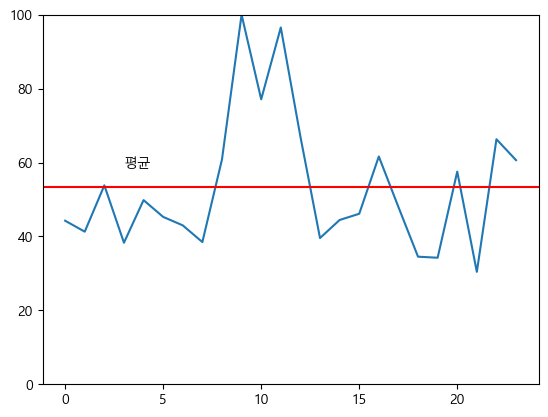

In [147]:
# 척도를 최대100 구간으로 변경 -- 사용자정의함수 활용
scaled_amt = zrmx_scl(sales02.amt) * 100

plt.plot(scaled_amt)
plt.ylim(0,100)
plt.axhline(scaled_amt.mean(), color='red')
# 평균값 보다 약간 위쪽에 선의 의미를 텍스트로 표시
plt.text(3, scaled_amt.mean()*1.1, '평균')
plt.show()

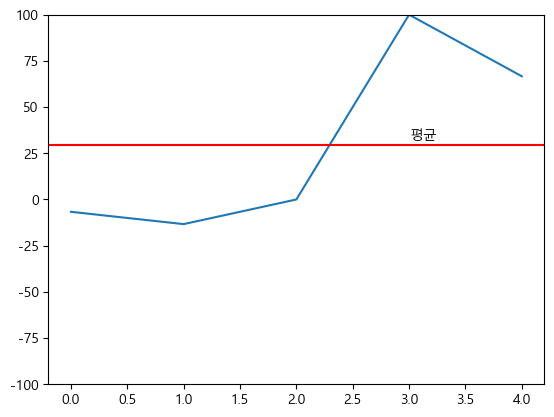

In [150]:
# 함수가 가진 가정의 의미를 확인하는 예제

# 음수값을 포함한 array
amts1 = np.array([-1,-2,0,15,10])
scaled_amt1 = zrmx_scl(amts1) * 100

plt.plot(scaled_amt1)
plt.ylim(-100,100)
plt.axhline(scaled_amt1.mean(), color='red')
plt.text(3, scaled_amt1.mean()*1.1, '평균')
plt.show()

# zrmx_scl은 모든 값이 양수인 경우에 유용
# 음수인 값이 존재하면 최대값의 의미 퇴색됨

In [151]:
# 값별 건수와 구성비를 dataframe 형태로 출력하는 함수

def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)

In [152]:
# 판매데이터 중 category 형식 변수 확인

sales[['lcat','scat','store']].tail()

,lcat,scat,store
41931,여성캐주얼,바지,Shoote gasan
41932,여성캐주얼,셔츠,Shoote gasan
41933,여성캐주얼,바지,Esteeme joongang
41934,남성캐주얼,바지,Shoote gasan
41935,여성캐주얼,바지,Multi bupyong


In [153]:
# 사용자정의함수를 활용해서 간편하게 분포 집계

cntnpcnt(sales.store)

,store,recCnt,pcntrecCnt
0,Esteeme joongang,2157,5.143552
1,Multi bupyong,11441,27.282049
2,ONL,12310,29.354254
3,Shoote city,5603,13.360836
4,Shoote gasan,10425,24.859309


<Axes: >

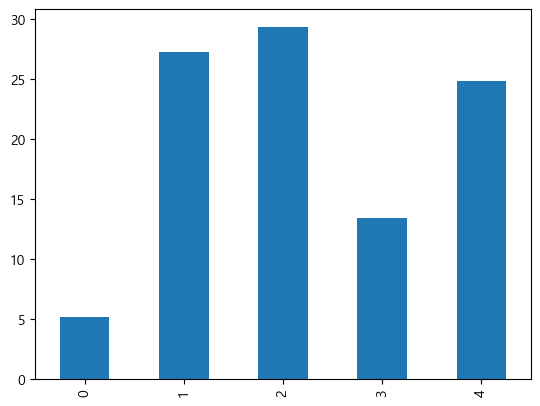

In [154]:
# 집계결과를 바로 시각화

cntnpcnt(sales.store).pcntrecCnt.plot(kind='bar')

[mini연습문제]
1. 고객의 연령과 구매한 상품의 사이즈간의 관계를 scatter를 사용해 시각화하라
2. 두 변수간의 관계를 선형회귀 모델에 의한 보조선을 추가해 확인하라

**[주의사항]** col 이나 size 같은 일반적인 단어들은 파이썬 언어 자체가 사용해야해서(i.e. 예약어 reserved word) 사용자가 변수명 등으로 사용하는 것이 부적절

[mini연습문제]

1. 상품별 사이즈와 가격 간의 관계를 scatter를 사용해 시각화하라
2. 두 변수간의 관계를 선형회귀 모델에 의한 보조선을 추가해 확인하라

## Section 3 : 다중회귀분석 적용
- 다중회귀분석 multiple regression analysis는 X 변수가 여러개인 경우
- 다수의 독립변수 X = {X1,X2,...Xn}를 사용해서 종속변수 Y를 추측하는 모델링

In [155]:
# 전체매출 월별집계 데이터 복제해 사용
# 복제 copy() 후 사용하면 원본값이 바뀌는 일은 없음
sales03 = sales02.copy()

# 시간(월) 순서를 일련번호로
sales03['seq'] = np.arange(len(sales02))

# 연도 무관한 월의 순서를 일련번호로 - 연도가 다르면 다시 시작
sales03['monSeq'] = np.append(np.arange(12), np.arange(12))

# 연도의 순서를 일련 번호로
sales03['yrSeq'] = np.repeat([0,1],12)
sales03

,saleMon,amt,seq,monSeq,yrSeq
0,2019-01,170950000,0,0,0
1,2019-02,159507000,1,1,0
2,2019-03,207905000,2,2,0
3,2019-04,147945000,3,3,0
4,2019-05,192484000,4,4,0
5,2019-06,174938000,5,5,0
6,2019-07,166080000,6,6,0
7,2019-08,148649000,7,7,0
8,2019-09,235010000,8,8,0
9,2019-10,386300000,9,9,0


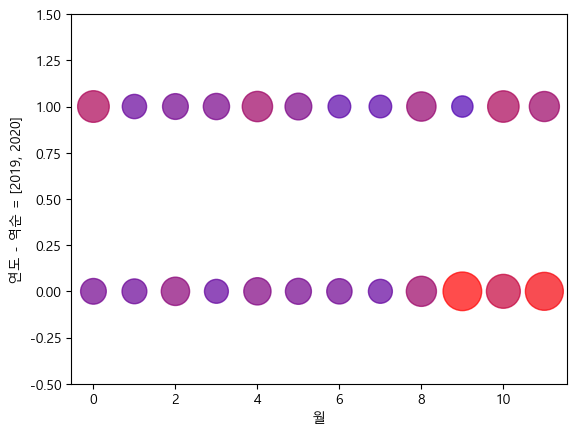

In [156]:
# 월별 매출이 전년과 비슷한 형태인지 확인하는 다른 시각화 방법

# 금액이 크면 붉은색, 작으면 보라색(짙은) 방향으로 표시하도록
colors1 = [[v,0,1-v] for v in sales03.amt/sales03.amt.max()]

# 점의 크기로도 금액 크기를 나타냄 (색상과 크기 보완적 활용)
plt.scatter(sales03.monSeq, sales03.yrSeq, 
            s=sales03.amt/5e+5, # 점크기 지정
            alpha=0.7,
            color=colors1)
plt.xlabel('월')
plt.ylabel('연도 - 역순 = [2019, 2020]')
plt.ylim(-0.5,1.5)
plt.show()

- X축의 월과 Y축의 연도 두 변수 모두가 회귀분석의 X 독립변수
- 즉, X1, X2 의 의미
- 색상과 크기는 Y (매출)

In [161]:
# scikit-learn 라이브러리의 선형회귀분석 모듈을 활용
from sklearn.linear_model import LinearRegression

# 다중선형회귀분석이므로 변수의 리스트를 활용
X = sales03[['monSeq','yrSeq']] # seq는 두 변수로 100% 설명되므로 제외 (중복정보)
y = sales03.amt

# fit() 은 데이터에서 모델을 추출하는 작업
reg = LinearRegression().fit(X, y)

reg.score(X, y)   # 결정계수 R2

# adjusted R-squared
# print(1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))


0.2561728211906531

- reg.score() 결과로 산출되는 결정계수 (coefficient of determination) 는 전체 데이터에서의 변동(variation) 중 얼마나 많은 부분을 모델이 설명하는가의 비율
- 0.256 이라는 값을 얻었다면 전체 변동 (X의 차이에 따른 y의 변화) 중에 1/4 정도만 모델이 설명한다는 의미
- 3/4는 모델이 포함한 요소로(즉, X 변수들) 설명할 수 없으니 모델이 예측하는 결과 그대로 될 가능성이 그리 크지는 않다 (**== 설명할 수 없는 변동이 크다 == 추가적인 외부 요소를 충분히 검토해보라**)

In [157]:
# 변수별 계수와 intercept
print(reg.coef_ , reg.intercept_)
print(['월순서의 계수', '연도순서의 계수'],'intercept')

[  3.09921965   0.67719403  -6.69855954 -24.47026146  -0.95638754
  -3.09562244   0.55298021 -21.89043882  -7.29483967] 100.82250779156766
['월순서의 계수', '연도순서의 계수'] intercept


- 계수의 의미 : 연초에 비해 연말로 갈수록 매출이 크다. (두 개 연도 밖에 없지만) 나중 연도의 매출이 작다
- 이 모델을 사용한 다음 해 매출 예측의 예상 결과: 그 다음 해는 매출이 더 줄어들 것이지만 그 안에서는 연말 쪽이 높은 패턴

#### 모델을 사용한 예측

In [162]:
# 다음 3개월에 대한 값을 모델을 사용해서 예측한다면?

data2predict = np.array([[0,3],[1,3],[2,3]])
# 3차년도의 1~3월
display(pd.DataFrame(data2predict))

# 예측결과 생성  SCORING
reg.predict(data2predict)


,0,1
0,0,3
1,1,3
2,2,3


array([77347426.2820512 , 86332833.62470855, 95318240.96736589])

In [163]:
# 예측값 계산을 위한 미래 데이터 생성

dfPreds = pd.DataFrame(np.array([[24,0,3],[25,1,3],[26,2,3]]))
dfPreds.columns = ['seq','monSeq','yrSeq']
display(dfPreds)

dfPreds.insert(0,'saleMon',['2021-01','2021-02','2021-03']) # 미래 월 추가
dfPreds.insert(1,'amt',reg.predict(np.array([[0,3],[1,3],[2,3]]))) # 미래 예측 매출액 추가

dfPreds

,seq,monSeq,yrSeq
0,24,0,3
1,25,1,3
2,26,2,3


,saleMon,amt,seq,monSeq,yrSeq
0,2021-01,7.734743e+07,24,0,3
1,2021-02,8.633283e+07,25,1,3
2,2021-03,9.531824e+07,26,2,3


In [164]:
# 두 테이블 결합
# (=과거의 이미 알고있는 실제값 테이블 + 모델에 의해 예측된 값 테이블)
sales02p = pd.concat([sales03,dfPreds])

# 두 테이블을 결합했기에 새로운 테이블에는 시간 순서대로 새로운 index 부여
sales02p.index = np.arange(len(sales02p))

# reset_index() 를 사용해서도 index 다시 부여 가능
# sales02p.reset_index(drop=True, inplace=True)

sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq
22,2020-11,2.561180e+08,22,10,1
23,2020-12,2.342350e+08,23,11,1
24,2021-01,7.734743e+07,24,0,3
25,2021-02,8.633283e+07,25,1,3
26,2021-03,9.531824e+07,26,2,3


In [165]:
sales02p['pred'] = reg.predict(np.array(sales02p[['monSeq','yrSeq']]))
sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq,pred
22,2020-11,2.561180e+08,22,10,1,2.304970e+08
23,2020-12,2.342350e+08,23,11,1,2.394824e+08
24,2021-01,7.734743e+07,24,0,3,7.734743e+07
25,2021-02,8.633283e+07,25,1,3,8.633283e+07
26,2021-03,9.531824e+07,26,2,3,9.531824e+07


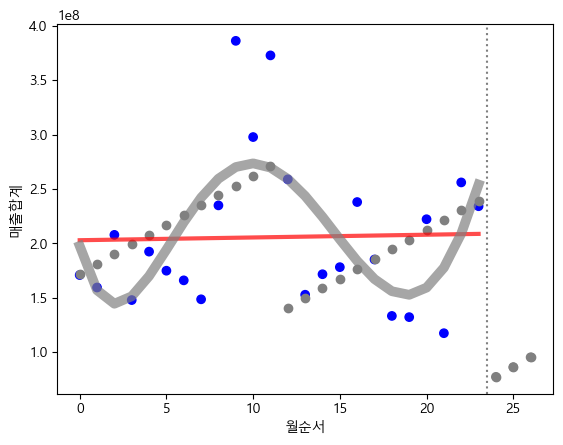

In [166]:
# 다중회귀분석을 통한 매출예측 결과 종합
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가

colors1 = np.where(sales02p.seq<24,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.amt, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')

varx = np.arange(len(sales02))
vary = sales02.amt
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='grey', linewidth=7, alpha=0.7)

plt.axvline(23.5, color='grey', linestyle=':')

plt.scatter(np.arange(len(sales02p)), sales02p['pred'], color='grey')
plt.show()

#### 계절성 지수 추가

,mon,meanMonAmt
0,01,0.708012
1,02,0.514467
2,03,0.625223
3,04,0.537198
4,05,0.709156
5,06,0.593243
6,07,0.493189
7,08,0.462669
8,09,0.753173
9,10,0.829744


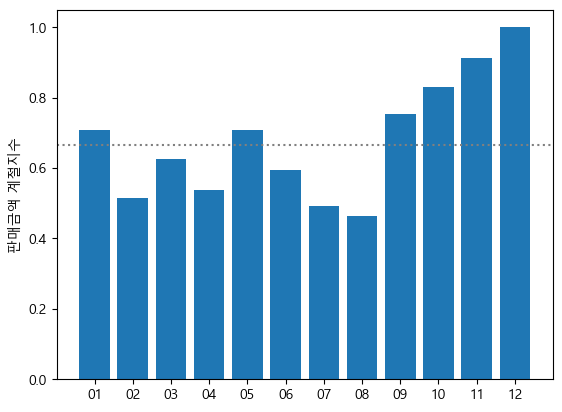

In [167]:
# 월의 순서만으로는 매출의 계절성을 표현하기 어려우므로
# 계절성을 명시적으로 보여주는 변수를 추가
# adding a derived feature

sales04 = sales03.copy()
sales04['mon'] = sales04.saleMon.str.slice(5,7)
# 연도와 무관한 월별 평균 산출
sales04m = sales04[['mon','amt']].groupby('mon').mean().reset_index()
sales04m.columns = ['mon', 'meanMonAmt']

# 계절의 매출지수를 변수로 추가 (최대값을 1로 scaling)
sales04m['meanMonAmt'] = zrmx_scl(sales04m['meanMonAmt'])

# 평균으로 나눈 지수도 사용 가능
# sales04m['meanMonAmt'] = sales04m['meanMonAmt']/sales04m['meanMonAmt'].mean()*100

display(sales04m)

plt.bar(sales04m.mon, sales04m.meanMonAmt)
plt.ylabel('판매금액 계절지수')
plt.axhline(sales04m.meanMonAmt.median(), color='grey', linestyle=':')
plt.show()

In [168]:
# 계절지수 결합

# 월별로 지수를 구한 것이므로 월을 기준으로 merge
sales05 = sales04.merge(sales04m, how='left', on='mon')
sales05

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt
0,2019-01,170950000,0,0,0,01,0.708012
1,2019-02,159507000,1,1,0,02,0.514467
2,2019-03,207905000,2,2,0,03,0.625223
3,2019-04,147945000,3,3,0,04,0.537198
4,2019-05,192484000,4,4,0,05,0.709156
5,2019-06,174938000,5,5,0,06,0.593243
6,2019-07,166080000,6,6,0,07,0.493189
7,2019-08,148649000,7,7,0,08,0.462669
8,2019-09,235010000,8,8,0,09,0.753173
9,2019-10,386300000,9,9,0,10,0.829744


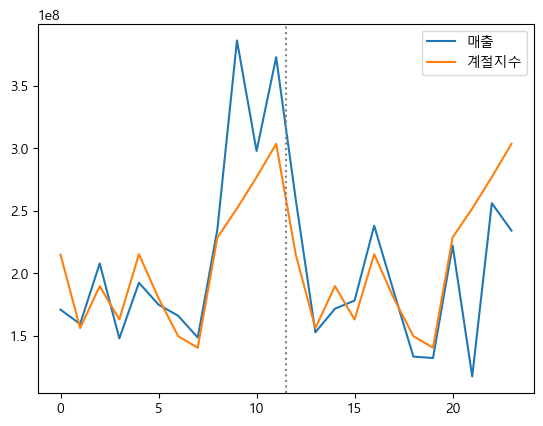

In [169]:
# 매출과 계절지수간 관계 확인

plt.plot(sales05.amt)
# 비교를 편하게 하기 위해 매출과 유사한 스케일로 계절지수를 변환
plt.plot(sales05.meanMonAmt / sales05.meanMonAmt.mean() * sales05.amt.mean())
plt.legend(['매출', '계절지수'])
plt.axvline(11.5, color='grey', linestyle=':')
plt.show()

In [170]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 모델 생성
# [월순서, 연도순서, 계절(금액)지수]
X = sales05[['monSeq', 'yrSeq', 'meanMonAmt']]
y = sales05.amt
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

# adjusted R-squared
# print(1 - (1-reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.5822278094429983

- 월별 매출 평균을 추가 적용한 결과 회귀분석 모델의 설명력 대폭 증가
- 계절적 변동이 매우 중요한 요소였음을 확인

In [171]:
dfPreds = pd.DataFrame(np.array([[24,0,3,'01'],[25,1,3,'02'],[26,2,3,'03']]))
dfPreds.columns = ['seq','monSeq','yrSeq','mon']
dfPreds['seq'] = dfPreds.seq.astype(int)
dfPreds['meanMonAmt'] = np.array(sales05.meanMonAmt[:3])
dfPreds.insert(0,'saleMon',['2021-01','2021-02','2021-03']) # 미래 월 추가

# 다중회귀분석 모델로 예측한 미래 매출액 추가
dfPreds.insert(1,'amt',reg.predict(np.array(dfPreds.tail(3)[['monSeq','yrSeq','meanMonAmt']]))) 
dfPreds

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt
0,2021-01,135815625.0,24,0,3,01,0.708012
1,2021-02,77060125.0,25,1,3,02,0.514467
2,2021-03,110683125.0,26,2,3,03,0.625223


In [172]:
sales02p = pd.concat([sales05,dfPreds])
sales02p.index = np.arange(len(sales02p))
sales02p.tail()
sales02p['pred'] = reg.predict(np.array(sales02p[['monSeq','yrSeq','meanMonAmt']]))
sales02p.tail()

,saleMon,amt,seq,monSeq,yrSeq,mon,meanMonAmt,pred
22,2020-11,256118000.0,22,10,1,11,0.912391,261155625.0
23,2020-12,234235000.0,23,11,1,12,1.000000,287751625.0
24,2021-01,135815625.0,24,0,3,01,0.708012,135815625.0
25,2021-02,77060125.0,25,1,3,02,0.514467,77060125.0
26,2021-03,110683125.0,26,2,3,03,0.625223,110683125.0


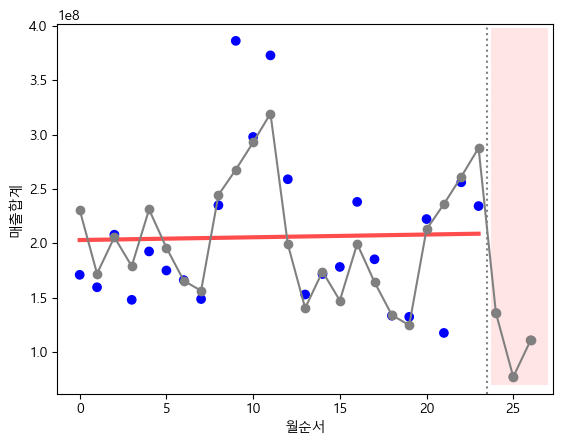

In [173]:
# 월순서와 매출합계간의 선형 추세선과 다중회귀분석을 통한 예측선 추가

colors1 = np.where(sales02p.seq<24,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.amt, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02))
vary = sales02.amt
# 선형추세선
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 1))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

# 미래기간에 대한 예측치를 포함한 추이 추가 표시
plt.plot(np.arange(len(sales02p)), sales02p['pred'], color='grey', marker='o')

plt.axvline(23.5, color='grey', linestyle=':')

# 선택영역 색상 구별
import matplotlib.patches as mpatches
left, bottom, width, height = (23.7, (1e+8)*.7, 3.3, (4e+8)*0.82)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

plt.show()

- [예측분석 결과] 2021년 초반의 3개월 : 계절성을 따르지만 추세상 과거에 비해 감소할 것이라는 전망치를 산출

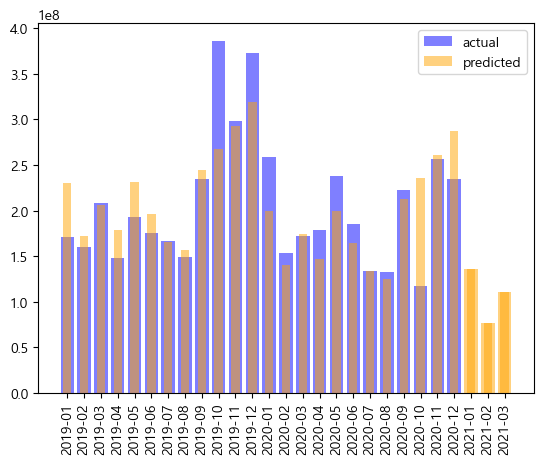

In [174]:
# 2020년 까지 2년간 실제값은 파란색으로 표시
colors1 = np.where(sales02p.seq<24,'blue','orange')

plt.bar(sales02p.saleMon, sales02p.amt, alpha=0.5, color=colors1)
# 다중회귀분석 결과는 오렌지색으로 예측치 표시
plt.bar(sales02p.saleMon, sales02p.pred, alpha=0.5, width=0.5, color='orange')
plt.xticks(rotation=90)
plt.legend(['actual', 'predicted'])
plt.show()

- 주의사항: 계절적인 변동을 적절히 반영하기 위해서는 (모델생성 즉 학습 용도로) 최소 3년간의 측정값이 필요

**다중회귀분석이 가능했던 이유 :**
- 시간순서, 연도, 월 등은 자동적으로 미래에 증가할 값을 알수 있음
- 매출계절지수 역시 월에 따라 고정되어 변화하지 않는다고 가정
- [주의] 미래의 값을 알 수 없는 변수를 예측모델의 변수(X 독립변수)로 사용하면 미래값 계산 불가능

#### 연도별 계절별 추이 비교 (**Monthly values Yearly comparisons**)

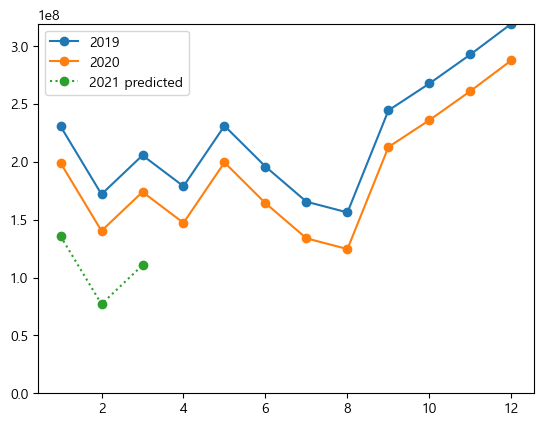

In [175]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화 (Monthly values Yearly comparisons)

plt.plot(np.arange(1, 13), sales02p['pred'][:12], marker='o')
plt.plot(np.arange(1, 13), sales02p['pred'][12:24], marker='o')

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 4),sales02p['pred'][24:], marker='o', linestyle=":")
plt.ylim(0,sales02p['pred'].max())
plt.legend([2019,2020,'2021 predicted'])
plt.show()

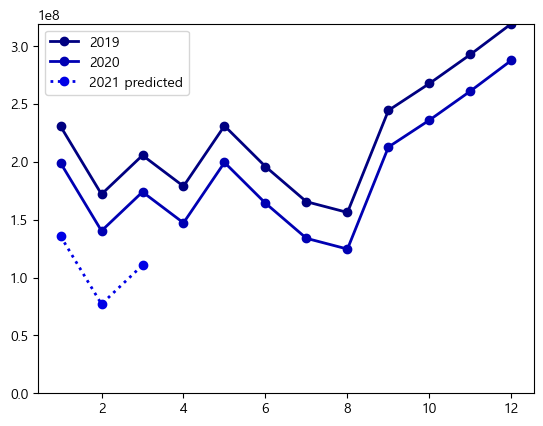

In [176]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화
# 색상을 단순화하고 추이를 나타낼 수 있도록 변경

colors1 = np.array([0.5,0.7,0.9]) 
# 색상을 지정하기 위한 RGB 값에 일정한 변화를 주는 방식

plt.plot(np.arange(1, 13), sales02p['pred'][:12],
         marker='o', color=[0,0,colors1[0]], linewidth=2)
plt.plot(np.arange(1, 13), sales02p['pred'][12:24], 
         marker='o', color=[0,0,colors1[1]], linewidth=2)

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 4),sales02p['pred'][24:], 
         marker='o', linestyle=":", color=[0,0,colors1[2]], linewidth=2)
plt.ylim(0,sales02p['pred'].max())
plt.legend(['2019','2020','2021 predicted'])
plt.show()

- [시각화 point] 단순화된 색상이지만 같은 **톤에서의 일정한 차이**로 인해 **추세의 변화임**을 설명하지 않아도 연도 차이를 느낄 수 있도록

### 회귀분석 - 통계 세부결과 확인 - statsmodels

In [177]:
import statsmodels.api as sm
# with statsmodels

# 독립변수 데이터 지정
X = sm.add_constant(X) 

# 종속변수 지정해 모델 생성
model = sm.OLS(y, X).fit()

# 모델을 통한 예측값 생성
predictions = model.predict(X) 
 
# 모델의 세부 결과 요약 출력
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    amt   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     9.291
Date:                Thu, 06 Jul 2023   Prob (F-statistic):           0.000472
Time:                        16:41:12   Log-Likelihood:                -456.70
No. Observations:                  24   AIC:                             921.4
Df Residuals:                      20   BIC:                             926.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.582e+07   4.49e+07      0.352      0.7

- 모델 전체로 보면 유의
- meanMonAmt 변수만 매우 유의 - 나머지 변수들은 유의한 수준은 아님
- 월순서를 나타내는 seq의 부호 양수
- 연도의 순서인 yrSeq 음수 - 시간이 지날수록 값이 줄어드는 관계가 나타남 (기간이 짧아 매우 유의하지는 않음)
<br><br>
- 2년간 월별 집계 데이터만 투입한 결과의 한계

In [178]:
# 독립변수(X) 들 사이에 강한 상관관계가 존재하는지 (=다중공선성) 확인

round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3)

,amt,seq,monSeq,yrSeq,meanMonAmt
amt,1.000,0.025,0.451,-0.230,0.728
seq,0.025,1.000,0.499,0.867,0.309
monSeq,0.451,0.499,1.000,0.000,0.620
yrSeq,-0.230,0.867,0.000,1.000,-0.000
meanMonAmt,0.728,0.309,0.620,-0.000,1.000


- amt와 meanMonAmt 관계 강함 -- 월별로 금액을 평균한 것이므로 당연

<Axes: >

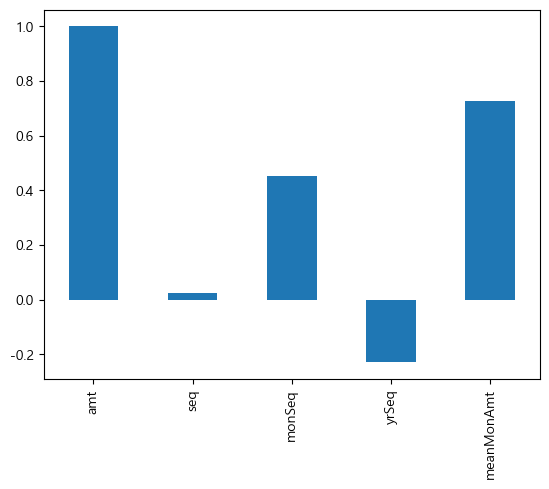

In [179]:
round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3).amt.plot(kind='bar')

# amt 자기 자신과의 관계는 1
# 연도순서 yrSeq 와는 반대방향의 상관관계

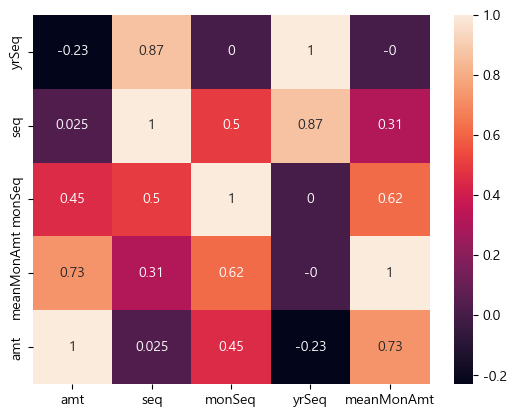

In [180]:
# 상관관계 테이블을 heatmap으로 시각화해 확인

import seaborn as sns

df4heatmap = round(sales05[['amt','seq', 'monSeq', 'yrSeq', 'mon', 'meanMonAmt']].corr(),3)
# 순서 정렬
df4heatmap = df4heatmap.sort_values('amt')
sns.heatmap(df4heatmap, annot=True)
plt.show()

[mini연습문제]

**1. 고객의 성별, 연령과 구매한 상품의 사이즈간의 관계를 다중회귀분석으로 분석하라


#### 회귀분석의 한계와 제약
- 여러 가정을 전제로 모델 성립
- 선형성이나 다중공선성(multi-colineartity) 등 관련 가정 충족 필요
- 현실에서는 가정을 모두 충족하지 않는 경우 많음
- 결국 모델링 방식이 너무 단순해 현실의 복잡한 특성을 충분히 담지 못함
<br><br>
- 현실에 가까운 모델을 만들기 위해 근래에는 비선형모델 또는 기계학습 머신러닝 machine learning 활용 증가

# 추가 연습문제

- 셔츠, 바지 등 소분류 상품군별 2021년 1개년 월별 매출 추이를 예측하라
- 남성, 여성 각각의 고객집단별 2021년 1개년 월별 매출 추이를 예측하라
- 상품코드 기준 매출이 가장 많은 5개 상품에 대해 2021년 1개년 월별 매출 추이를 예측하라
- 점포별 2021년 1개년 월별 매출 추이를 예측하라

## Section 4 :  또 다른 가상의 매출데이터를 사용한 미래예측 예제



- 두 개 임의의 패션 브랜드를 GT Mix해 가상의 매출 데이터 생성

In [181]:
'''
tmpdfA1 = pd.read_csv(dataPath + 'a_corona.csv', encoding='euc-kr')
tmpdfA2 = pd.read_csv(dataPath + 'a_kakaoStyle.csv', encoding='euc-kr')[['kakaoStyle']]
tmpdfA3 = pd.read_csv(dataPath + 'a_musinsa.csv', encoding='euc-kr')[['musinsa']]
tmpdfA4 = pd.read_csv(dataPath + 'a_uniqlo.csv', encoding='euc-kr')[['uniqlo']]
salesu = pd.concat([tmpdfA1, tmpdfA2, tmpdfA3,tmpdfA4], axis=1)
'''

# salesu = salesu
salesu = pd.read_csv(dataPath + 'GT_uniql_kaka.csv', encoding='euc-kr').iloc[:,1:]
# salesu.to_csv('GT_unicl_kaka.csv')

,date,corona,kakaoStyle,musinsa,uniqlo
256,2022-03-13,31.0,71,54,15
257,2022-03-20,25.0,59,49,18
258,2022-03-27,21.0,58,56,14
259,2022-04-03,17.0,42,55,19
260,2022-04-10,15.0,67,62,21


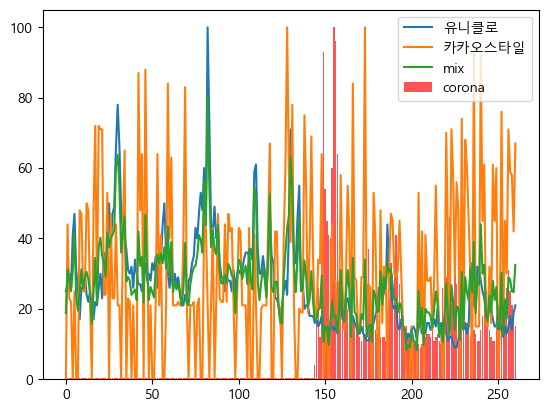

In [182]:
display(salesu.tail())
plt.plot(np.arange(len(salesu)), salesu.uniqlo)
plt.plot(np.arange(len(salesu)), salesu.kakaoStyle)
plt.plot(np.arange(len(salesu)), (salesu.kakaoStyle + (salesu.uniqlo*3))/4)
plt.bar(np.arange(len(salesu)), salesu.corona, 
        alpha=0.67, color='red')
plt.legend(['유니클로','카카오스타일','mix', 'corona'])
plt.show()

# 주단위로 집계된 검색지수

In [63]:
salesu[salesu.columns[1:]].corr()

,corona,kakaoStyle,musinsa,uniqlo
corona,1.000000,0.025458,0.206729,-0.485714
kakaoStyle,0.025458,1.000000,0.076694,-0.132802
musinsa,0.206729,0.076694,1.000000,0.056667
uniqlo,-0.485714,-0.132802,0.056667,1.000000


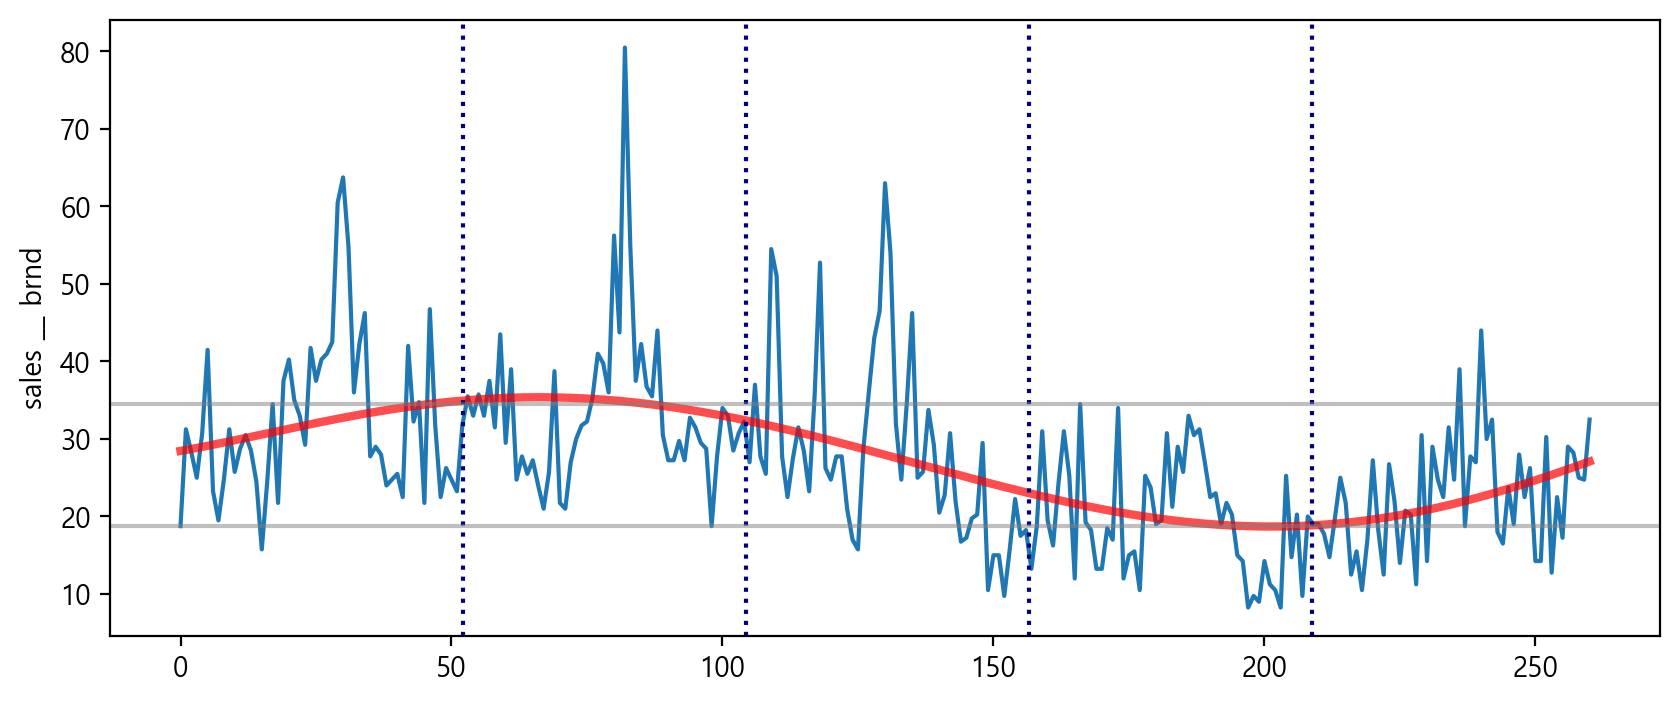

In [183]:
# a virtual series of sales for sales forecasting example

plt.figure(figsize=(10,4), dpi=200)
plt.plot(np.arange(len(salesu)), (salesu.kakaoStyle + (salesu.uniqlo*3))/4)
intervali = len(salesu)/5

varx = np.arange(len(salesu))
vary = (salesu.kakaoStyle + (salesu.uniqlo*3))/4
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

for i in np.arange(4):
    plt.axvline((i+1)*intervali , color='navy', linestyle=":" )   
plt.ylabel('sales __ brnd') 
plt.axhline(vary.quantile(0.8), color='grey', alpha=0.5)
plt.axhline(vary.quantile(0.2), color='grey', alpha=0.5)
plt.show()


- 월단위로 전환 필요

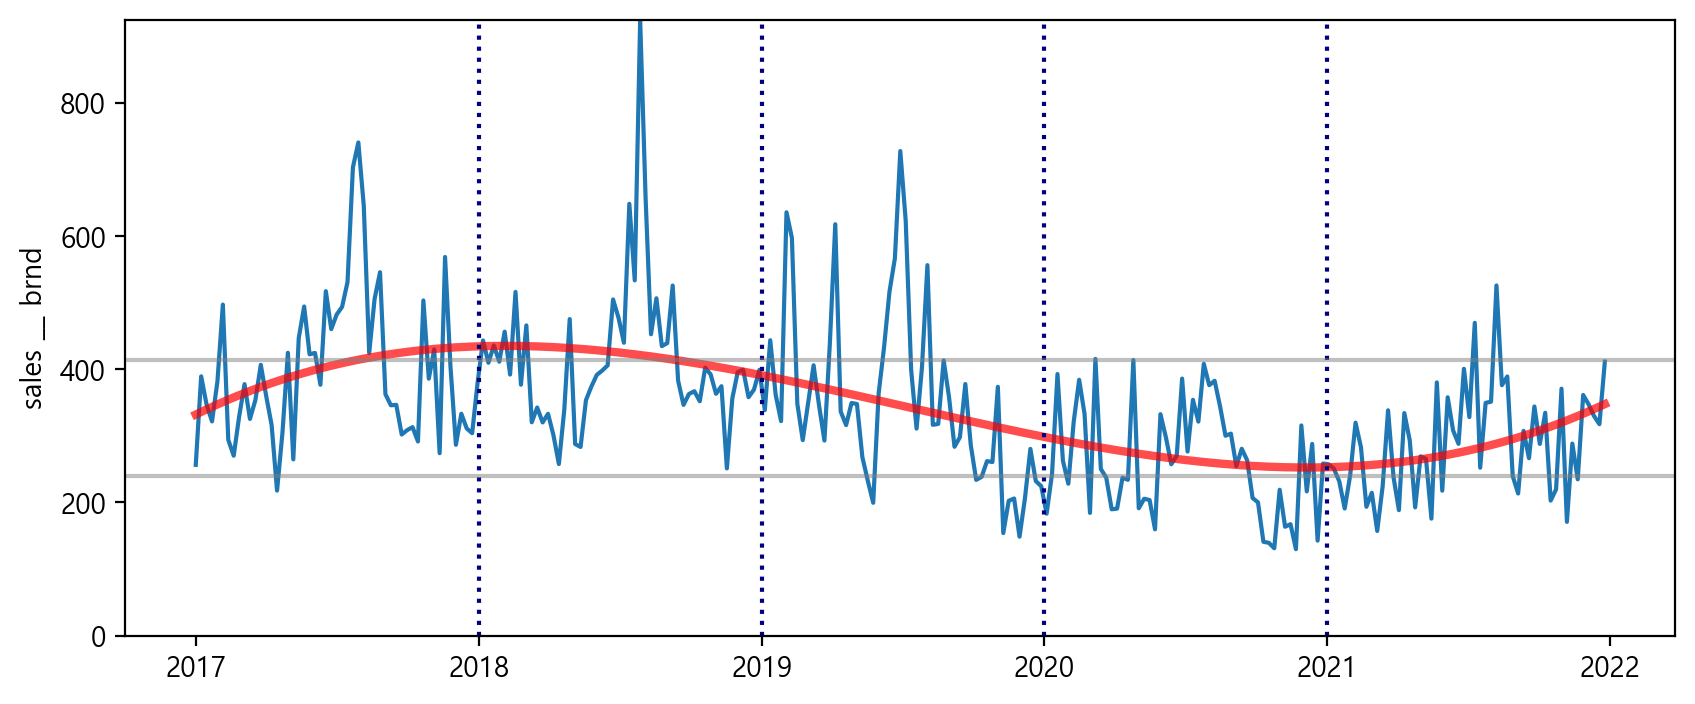

In [184]:
# a virtual series of sales for sales forecasting example

startyr = 2017
yearSeries = np.arange(len(salesu))/len(salesu)*5 +startyr
saleSeries = (salesu.kakaoStyle + (salesu.uniqlo*3))/4 + 4
saleSeries = rjitt(saleSeries)*11
salesu['saleSeries'] = saleSeries

plt.figure(figsize=(10,4), dpi=200)
plt.plot(yearSeries, saleSeries)
intervali = 1

varx = yearSeries
vary = saleSeries
# 차수==1 (선형)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 5))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)

for i in np.arange(4):
    plt.axvline(i+startyr+1 , color='navy', linestyle=":" )   
plt.ylabel('sales __ brnd') 
plt.axhline(vary.quantile(0.8), color='grey', alpha=0.5)
plt.axhline(vary.quantile(0.2), color='grey', alpha=0.5)
plt.ylim(0, np.max(saleSeries))
plt.show()


### 과제: 가상 매출 데이터의 2022년 매출 영역을 이전 데이터만을 사용해서 예측하라

In [185]:
salesu.tail()

,date,corona,kakaoStyle,musinsa,uniqlo,saleSeries
256,2022-03-13,31.0,71,54,15,361.404060
257,2022-03-20,25.0,59,49,18,347.361264
258,2022-03-27,21.0,58,56,14,329.816472
259,2022-04-03,17.0,42,55,19,317.498902
260,2022-04-10,15.0,67,62,21,411.476683


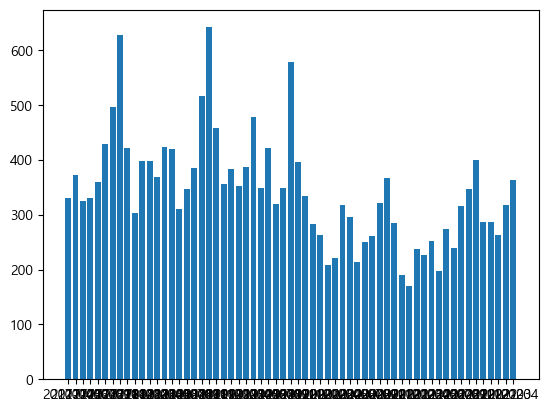

In [186]:
salesu1 = salesu.copy()
salesu1['mon'] = salesu1.date.str.slice(0,7)
salesu2 = salesu1[['mon', 'saleSeries']].groupby('mon').mean().reset_index()
plt.bar(salesu2.mon,salesu2.saleSeries)
plt.show()

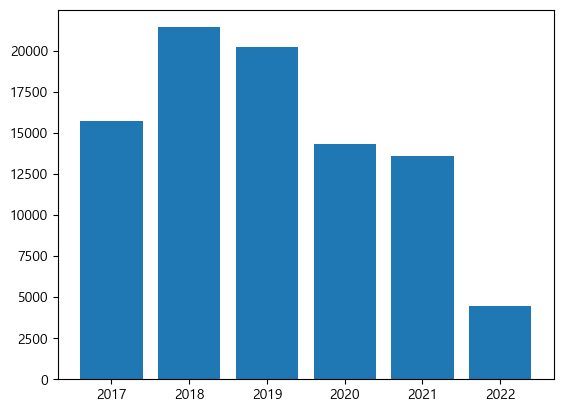

In [187]:
salesu1 = salesu.copy()
salesu1['yr'] = salesu1.date.str.slice(0,4)
salesu2 = salesu1[['yr', 'saleSeries']].groupby('yr').sum().reset_index()
plt.bar(salesu2.yr,salesu2.saleSeries)
plt.show()

In [188]:
salesu1 = salesu.copy()
print(salesu1.shape)
salesu1['mon'] = salesu1.date.str.slice(0,7)
display(salesu1.tail())

# msm : monthly sales modeling
salesu_msm = salesu1[['mon','corona', 'musinsa', 'uniqlo', 'kakaoStyle', 'saleSeries']].groupby('mon').mean().reset_index()
display(salesu_msm.tail())
print(salesu_msm.shape)

# 다음해 동월 변수 생성
salesu_msm['saleNxyr'] = np.append( salesu_msm.tail(len(salesu_msm)-12).saleSeries, np.repeat(0,12))

# 다음 달
salesu_msm['saleNxmn'] = np.append( salesu_msm.tail(len(salesu_msm)-1).saleSeries, np.repeat(0,1))
# 다다음 달
salesu_msm['saleNxmn2'] = np.append( salesu_msm.tail(len(salesu_msm)-2).saleSeries, np.repeat(0,2))
# 세번째 미래 달
salesu_msm['saleNxmn3'] = np.append( salesu_msm.tail(len(salesu_msm)-3).saleSeries, np.repeat(0,3))

# 다음 달과 다다음 달은 뒤에 사용


salesu_msm.tail()

(261, 6)


,date,corona,kakaoStyle,musinsa,uniqlo,saleSeries,mon
256,2022-03-13,31.0,71,54,15,361.404060,2022-03
257,2022-03-20,25.0,59,49,18,347.361264,2022-03
258,2022-03-27,21.0,58,56,14,329.816472,2022-03
259,2022-04-03,17.0,42,55,19,317.498902,2022-04
260,2022-04-10,15.0,67,62,21,411.476683,2022-04


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries
56,2021-12,19.25,48.75,20.0,30.75,287.415486
57,2022-01,14.60,45.80,17.2,36.40,287.141905
58,2022-02,23.00,55.25,14.0,37.75,262.390131
59,2022-03,25.75,53.00,15.0,54.50,318.317938
60,2022-04,16.00,58.50,20.0,54.50,364.487792


(61, 6)


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3
56,2021-12,19.25,48.75,20.0,30.75,287.415486,0.0,287.141905,262.390131,318.317938
57,2022-01,14.60,45.80,17.2,36.40,287.141905,0.0,262.390131,318.317938,364.487792
58,2022-02,23.00,55.25,14.0,37.75,262.390131,0.0,318.317938,364.487792,0.000000
59,2022-03,25.75,53.00,15.0,54.50,318.317938,0.0,364.487792,0.000000,0.000000
60,2022-04,16.00,58.50,20.0,54.50,364.487792,0.0,0.000000,0.000000,0.000000


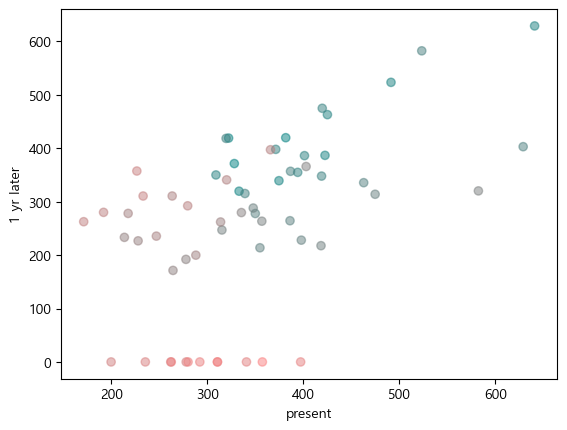

In [70]:
colors1 = [[x/len(salesu_msm),0.5,0.5] for x in salesu_msm.index] 
# colors1 = np.where(salesu_msm.saleNxyr==0,[1,1,1],colors1)
plt.scatter(salesu_msm.saleSeries, salesu_msm.saleNxyr,
           alpha=0.5,
           color=colors1)
plt.xlabel('present')
plt.ylabel('1 yr later')
plt.show()

### 다중회귀분석 적용
- 다중회귀분석 multiple regression analysis는 다수의 독립변수 X = {X1,X2,...Xn}를 사용해서 종속변수 Y를 추측하는 모델링

In [189]:
sales03 = salesu_msm.copy().tail(60)
display(salesu_msm.tail())

mons = np.array(sales03.mon)

# 시간적인 순서를 일련번호로
sales03['seq'] = np.arange(len(sales03))
print(sales03.shape)

# 월의 순서를 일련번호로 - 연도가 다르면 다시 시작
monSeqs = np.array(pd.DataFrame(np.array([np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]+[np.arange(12)]).flatten()).tail(68).head(60))
sales03['monSeq'] = monSeqs 

# 연도의 순서를 일련 번호로
sales03['yrSeq'] = np.repeat([0,1,2,3,4,5],12)[2:][:60]
sales03.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3
56,2021-12,19.25,48.75,20.0,30.75,287.415486,0.0,287.141905,262.390131,318.317938
57,2022-01,14.60,45.80,17.2,36.40,287.141905,0.0,262.390131,318.317938,364.487792
58,2022-02,23.00,55.25,14.0,37.75,262.390131,0.0,318.317938,364.487792,0.000000
59,2022-03,25.75,53.00,15.0,54.50,318.317938,0.0,364.487792,0.000000,0.000000
60,2022-04,16.00,58.50,20.0,54.50,364.487792,0.0,0.000000,0.000000,0.000000


(60, 11)


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq
56,2021-12,19.25,48.75,20.0,30.75,287.415486,0.0,287.141905,262.390131,318.317938,55,11,4
57,2022-01,14.60,45.80,17.2,36.40,287.141905,0.0,262.390131,318.317938,364.487792,56,0,4
58,2022-02,23.00,55.25,14.0,37.75,262.390131,0.0,318.317938,364.487792,0.000000,57,1,4
59,2022-03,25.75,53.00,15.0,54.50,318.317938,0.0,364.487792,0.000000,0.000000,58,2,5
60,2022-04,16.00,58.50,20.0,54.50,364.487792,0.0,0.000000,0.000000,0.000000,59,3,5


,mon,meanMonAmt
0,01,0.584057
1,02,0.606422
2,03,0.622050
3,04,0.644653
4,05,0.758837
5,06,0.651782
6,07,0.637190
7,08,0.622562
8,09,0.715007
9,10,0.929371


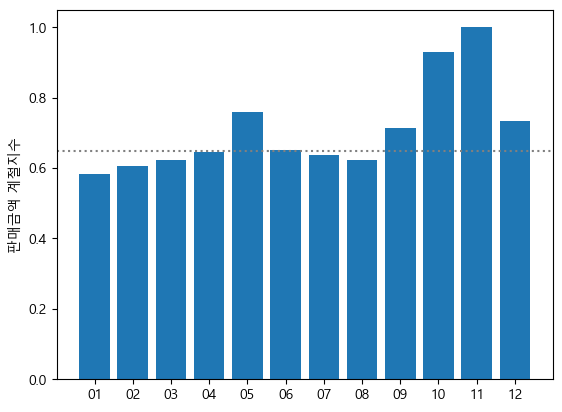

In [190]:
# 월의 순서만으로는 매출의 계절성을 표현하기 어려우므로
# 계절성을 명시적으로 보여주는 변수를 생성해 모델링에 추가
# adding a derived feature

sales04 = sales03.copy()
sales04['mon'] = sales04.mon.str.slice(5,7)
sales04m = sales04[['mon','saleSeries']].groupby('mon').mean().reset_index()
sales04m.columns = ['mon', 'meanMonAmt']

# 계절의 매출지수를 변수로 추가
sales04m['meanMonAmt'] = zrmx_scl(sales04m['meanMonAmt'])
display(sales04m)

plt.bar(sales04m.mon, sales04m.meanMonAmt)
plt.ylabel('판매금액 계절지수')
plt.axhline(sales04m.meanMonAmt.median(), color='grey', linestyle=':')
plt.show()

In [191]:
sales05 = sales04.merge(sales04m, how='left', on='mon')
# 누적평균 변수생성
sales05['coronaCummean'] = sales05.corona.expanding().mean()
sales05.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean
55,12,19.25,48.75,20.0,30.75,287.415486,0.0,287.141905,262.390131,318.317938,55,11,4,0.733205,9.850000
56,01,14.60,45.80,17.2,36.40,287.141905,0.0,262.390131,318.317938,364.487792,56,0,4,0.584057,9.933333
57,02,23.00,55.25,14.0,37.75,262.390131,0.0,318.317938,364.487792,0.000000,57,1,4,0.606422,10.158621
58,03,25.75,53.00,15.0,54.50,318.317938,0.0,364.487792,0.000000,0.000000,58,2,5,0.622050,10.422881
59,04,16.00,58.50,20.0,54.50,364.487792,0.0,0.000000,0.000000,0.000000,59,3,5,0.644653,10.515833


In [192]:
sales05.columns

Index(['mon', 'corona', 'musinsa', 'uniqlo', 'kakaoStyle', 'saleSeries',
       'saleNxyr', 'saleNxmn', 'saleNxmn2', 'saleNxmn3', 'seq', 'monSeq',
       'yrSeq', 'meanMonAmt', 'coronaCummean'],
      dtype='object')

In [193]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음해 동월을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
X = sales05.head(48)[feats]
y = sales05.head(48).saleNxyr
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

0.8066725544495718

In [194]:
sales05['predSales'] = np.array(reg.predict(sales05[feats]))
sales05['yrmon'] = mons 
display(sales05.head())
sales05.tail()

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
0,05,0.5,23.50,36.25,11.75,373.624566,423.877050,325.500604,330.723674,360.267003,0,4,0,0.758837,0.5,502.364156,2017-05
1,06,0.5,22.25,23.75,30.00,325.500604,419.831061,330.723674,360.267003,429.503685,1,5,0,0.651782,0.5,409.602190,2017-06
2,07,0.5,25.00,24.40,29.20,330.723674,310.881080,360.267003,429.503685,496.866920,2,6,0,0.637190,0.5,379.524405,2017-07
3,08,0.5,27.75,21.50,53.75,360.267003,346.421625,429.503685,496.866920,628.599934,3,7,0,0.622562,0.5,383.634985,2017-08
4,09,0.5,36.00,30.00,47.50,429.503685,384.642189,496.866920,628.599934,421.280727,4,8,0,0.715007,0.5,364.947644,2017-09


,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
55,12,19.25,48.75,20.0,30.75,287.415486,0.0,287.141905,262.390131,318.317938,55,11,4,0.733205,9.850000,317.181727,2021-12
56,01,14.60,45.80,17.2,36.40,287.141905,0.0,262.390131,318.317938,364.487792,56,0,4,0.584057,9.933333,241.547949,2022-01
57,02,23.00,55.25,14.0,37.75,262.390131,0.0,318.317938,364.487792,0.000000,57,1,4,0.606422,10.158621,207.414169,2022-02
58,03,25.75,53.00,15.0,54.50,318.317938,0.0,364.487792,0.000000,0.000000,58,2,5,0.622050,10.422881,183.704096,2022-03
59,04,16.00,58.50,20.0,54.50,364.487792,0.0,0.000000,0.000000,0.000000,59,3,5,0.644653,10.515833,172.262331,2022-04


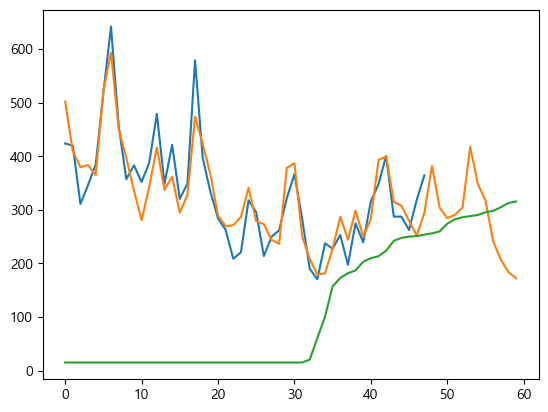

In [195]:
plt.plot(sales05.head(48).saleNxyr)
plt.plot(sales05.predSales)
plt.plot(sales05.coronaCummean*30)
plt.show()

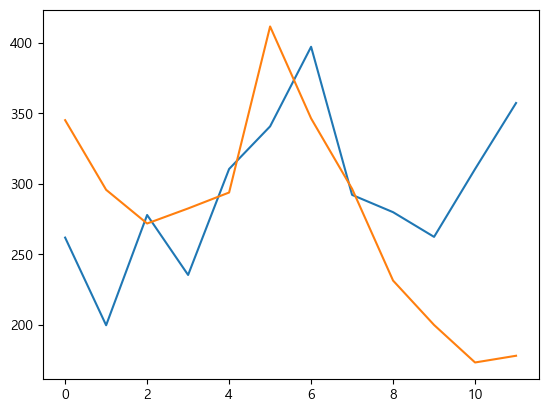

In [78]:
plt.plot(np.array(sales05.tail(12).saleSeries))
plt.plot(np.array(sales05.tail(12).predSales))

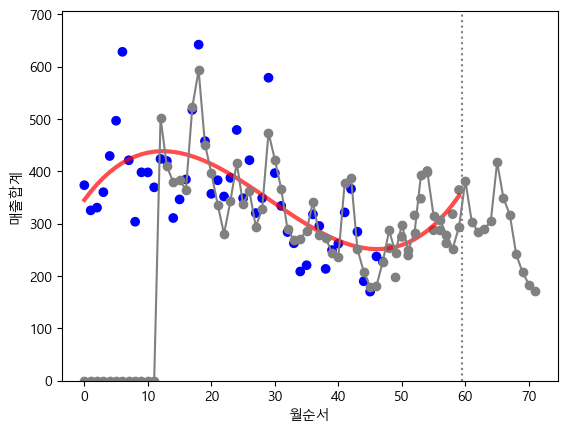

In [196]:
# 월순서와 매출합계간의 선형, polynomial 회귀선 추가
sales02p = sales05.copy()
sales02p['pred'] = reg.predict(sales02p[feats])
colors1 = np.where(sales02p.seq<48,'blue','grey')
plt.scatter(np.arange(len(sales02p)), sales02p.saleSeries, color=colors1)
plt.xlabel('월순서')
plt.ylabel('매출합계')
varx = np.arange(len(sales02p))
vary = sales02p.saleSeries
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=3, alpha=0.7)
plt.axvline(59.5, color='grey', linestyle=':')

# 미래기간에 대한 예측치를 포함한 추이 추가 표시
plt.plot(np.arange(len(sales02p)+12), list(np.repeat(0,12)) + list(sales02p['pred']), color='grey', marker='o')
plt.ylim(0,sales02p.saleSeries.max()*1.1)
plt.show()

- [예측분석 결과] 2022년 어느 정도는 반등한다는 전망치를 산출

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon,pred
55,12,19.25,48.75,20.0,30.75,292.244977,0.0,279.990777,262.487396,310.564325,55,11,4,0.737089,9.850000,296.566814,2021-12,296.566814
56,01,14.60,45.80,17.2,36.40,279.990777,0.0,262.487396,310.564325,357.360528,56,0,4,0.578385,9.933333,231.517776,2022-01,231.517776
57,02,23.00,55.25,14.0,37.75,262.487396,0.0,310.564325,357.360528,0.000000,57,1,4,0.609858,10.158621,200.053874,2022-02,200.053874
58,03,25.75,53.00,15.0,54.50,310.564325,0.0,357.360528,0.000000,0.000000,58,2,5,0.618468,10.422881,173.465421,2022-03,173.465421
59,04,16.00,58.50,20.0,54.50,357.360528,0.0,0.000000,0.000000,0.000000,59,3,5,0.649167,10.515833,178.227881,2022-04,178.227881


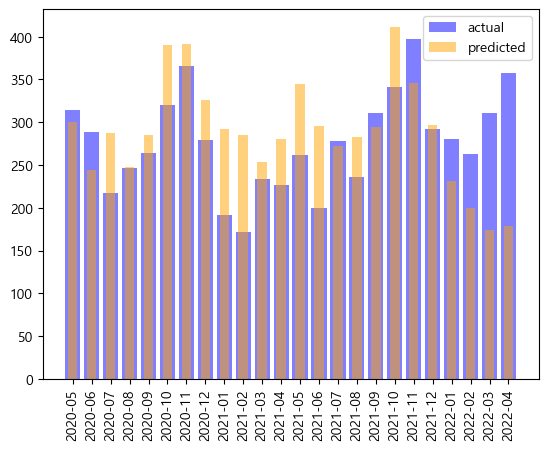

In [80]:
# 2020년 까지 2년간 실제값은 파란색으로 표시

sales02pa = sales02p.tail(24)
colors1 = np.where(sales02p.seq<48,'blue','orange')

display(sales02pa.tail())

plt.bar(sales02pa.yrmon, sales02pa.saleSeries, alpha=0.5, color=colors1)
# 다중회귀분석 결과는 오렌지색으로 예측치 표시
plt.bar(sales02pa.yrmon, sales02pa.pred, alpha=0.5, width=0.5, color='orange')
plt.xticks(rotation=90)
plt.legend(['actual', 'predicted'])
plt.show()

- 주의사항: 계절적인 변동을 적절히 반영하기 위해서는 (모델생성 즉 학습 용도로) 최소 3년간의 측정값이 필요

#### 연도별 계절별 추이 비교 (**Monthly values Yearly comparisons**)

In [81]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화 (Monthly values Yearly comparisons)


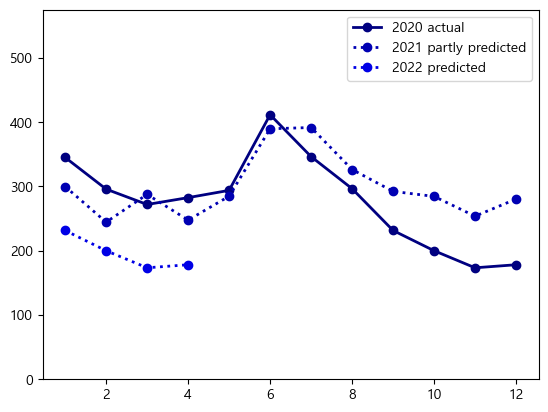

In [82]:
# 월기준으로 겹쳐서 연도별 추이를 비교하는 시각화
# 색상을 단순화하고 추이를 나타낼 수 있도록 변경

colors1 = np.array([0.5,0.7,0.9]) 
# 색상을 지정하기 위한 RGB 값에 일정한 변화를 주는 방식


plt.plot(np.arange(1, 13), sales02p.tail(12)['pred'],
         marker='o', color=[0,0,colors1[0]], linewidth=2)
plt.plot(np.arange(1, 13), sales02p.tail(24).head(12)['pred'],
         marker='o', linestyle=":",color=[0,0,colors1[1]], linewidth=2)

# 실제값과 예측치는 구별되도록 표시 (dotted)
plt.plot(np.arange(1, 5), sales02p.tail(4)['pred'],
         marker='o', linestyle=":", color=[0,0,colors1[2]], linewidth=2)
plt.ylim(0,sales02p['pred'].max())
plt.legend(['2020 actual','2021 partly predicted','2022 predicted'])
plt.show()

**[ Considerations ]**
- 다음해 동월을 예측하는 모델을 사용하게되면 가까운 미래 구간에 대해서는 최신 데이터가 존재함에도 사용하지 않는 문제 발생
- 12개 모델을 만드는 방식 고려 필요
- 정밀한 예측을 위해 복잡하게 모델을 만들 것인지 정밀함을 희생하고 단순하게 할 것인지 판단 필요

### 각 월별 별도 모델을 활용하는 예측

In [83]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음달을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
X = sales05.head(59)[feats]
y = sales05.head(59).saleNxmn
reg = LinearRegression().fit(X, y)

reg.score(X,y)

0.49548619221849555

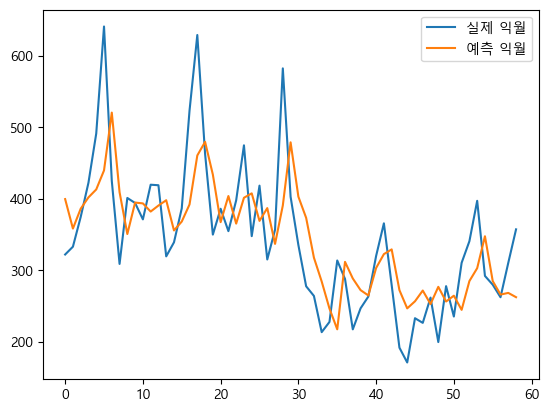

In [84]:
plt.plot(y)
plt.plot(reg.predict(X))
plt.legend(['실제 익월', '예측 익월'])
plt.show()

- 정확도가 낮은 이유는 다음 달의 특성을 충분히 반영해주지 않았기 때문 (X features)
- 예측결과가 전달의 값에 의존하는듯한 양상

In [85]:
sales05.head(59).tail(3)

,mon,corona,musinsa,uniqlo,kakaoStyle,saleSeries,saleNxyr,saleNxmn,saleNxmn2,saleNxmn3,seq,monSeq,yrSeq,meanMonAmt,coronaCummean,predSales,yrmon
56,01,14.60,45.80,17.2,36.40,279.990777,0.0,262.487396,310.564325,357.360528,56,0,4,0.578385,9.933333,231.517776,2022-01
57,02,23.00,55.25,14.0,37.75,262.487396,0.0,310.564325,357.360528,0.000000,57,1,4,0.609858,10.158621,200.053874,2022-02
58,03,25.75,53.00,15.0,54.50,310.564325,0.0,357.360528,0.000000,0.000000,58,2,5,0.618468,10.422881,173.465421,2022-03


### 각 예측대상 월별 모델 개발

In [86]:
# 다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats = sales05.tail(59)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats.columns = list(dfnxmonFeats.columns + '_nxmn')
dfnxmonFeats.tail()

,monSeq_nxmn,yrSeq_nxmn,meanMonAmt_nxmn
54,11,4,0.737089
55,0,4,0.578385
56,1,4,0.609858
57,2,5,0.618468
58,3,5,0.649167


In [87]:
# 다음 달에 대한 변수를 결합

dfnxmnSfcst1 = sales05.head(59)[feats + ['saleNxmn']]
display(dfnxmnSfcst1.tail())
# 다음 달의 값을 옆으로 결합해 줌
dfnxmnSfcst1 = pd.concat([dfnxmnSfcst1, dfnxmonFeats], axis=1)
dfnxmnSfcst1.tail()

,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn
54,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,292.244977
55,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.0,30.75,279.990777
56,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.2,36.40,262.487396
57,262.487396,1,4,0.609858,23.00,10.158621,55.25,14.0,37.75,310.564325
58,310.564325,2,5,0.618468,25.75,10.422881,53.00,15.0,54.50,357.360528


,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn,monSeq_nxmn,yrSeq_nxmn,meanMonAmt_nxmn
54,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,292.244977,11,4,0.737089
55,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.0,30.75,279.990777,0,4,0.578385
56,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.2,36.40,262.487396,1,4,0.609858
57,262.487396,1,4,0.609858,23.00,10.158621,55.25,14.0,37.75,310.564325,2,5,0.618468
58,310.564325,2,5,0.618468,25.75,10.422881,53.00,15.0,54.50,357.360528,3,5,0.649167


In [88]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다음달을 예측하는 모델 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn', 'yrSeq_nxmn', 'meanMonAmt_nxmn']
X = dfnxmnSfcst1[feats]
y = dfnxmnSfcst1.saleNxmn
reg1 = LinearRegression().fit(X, y)

reg1.score(X,y)

# 결정계수값 대폭 증가 - 이미 알고 있는 미래의 월 순서와 금액을 추가로 투입했기 때문

0.7793149999798237

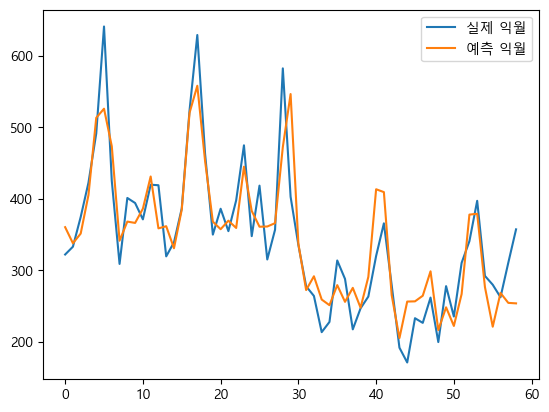

In [89]:
plt.plot(y)
plt.plot(reg1.predict(X))
plt.legend(['실제 익월', '예측 익월'])
plt.show()

In [90]:
# 다다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats2 = sales05.tail(58)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats2.columns = list(dfnxmonFeats2.columns + '_nxmn2')
dfnxmonFeats2.tail()

# 다다음 달에 대한 변수를 결합한 테이블 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
dfnxmn2Sfcst = sales05.head(58)[['yrmon'] + feats + ['saleNxmn2']]
display(dfnxmn2Sfcst.tail())
dfnxmn2Sfcst = pd.concat([dfnxmn2Sfcst, dfnxmonFeats2], axis=1)
dfnxmn2Sfcst.tail()

,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn2
53,2021-10,340.805618,9,4,0.927003,13.20,9.608333,51.60,24.2,36.60,292.244977
54,2021-11,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,279.990777
55,2021-12,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.0,30.75,262.487396
56,2022-01,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.2,36.40,310.564325
57,2022-02,262.487396,1,4,0.609858,23.00,10.158621,55.25,14.0,37.75,357.360528


,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn2,monSeq_nxmn2,yrSeq_nxmn2,meanMonAmt_nxmn2
53,2021-10,340.805618,9,4,0.927003,13.20,9.608333,51.60,24.2,36.60,292.244977,11,4,0.737089
54,2021-11,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.0,41.75,279.990777,0,4,0.578385
55,2021-12,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.0,30.75,262.487396,1,4,0.609858
56,2022-01,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.2,36.40,310.564325,2,5,0.618468
57,2022-02,262.487396,1,4,0.609858,23.00,10.158621,55.25,14.0,37.75,357.360528,3,5,0.649167


In [91]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다다음 달 값을 예측하는 모델 생성
feats2 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn2', 'yrSeq_nxmn2', 'meanMonAmt_nxmn2']
X = dfnxmn2Sfcst[feats2]
y = dfnxmn2Sfcst.saleNxmn2
reg2 = LinearRegression().fit(X, y)

reg2.score(X,y)

0.7824357852228446

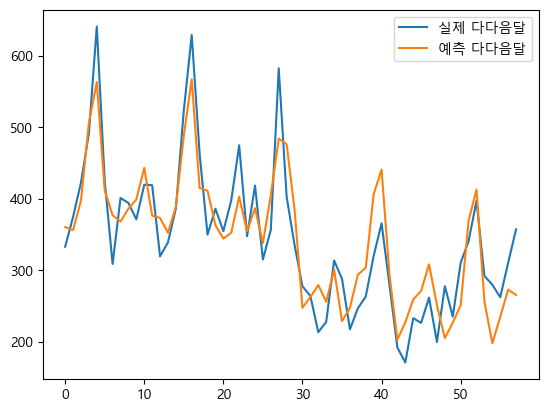

In [92]:
plt.plot(y)
plt.plot(reg2.predict(X))
plt.legend(['실제 다다음달', '예측 다다음달'])
plt.show()

In [93]:
# 다다음 달의 월, 연도 순번과 계절지수 추출

dfnxmonFeats3 = sales05.tail(57)[['monSeq', 'yrSeq', 'meanMonAmt']].copy().reset_index(drop=True)
dfnxmonFeats3.columns = list(dfnxmonFeats3.columns + '_nxmn3')
dfnxmonFeats3.tail()

# 다다음 달에 대한 변수를 결합한 테이블 생성
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle']
dfnxmn3Sfcst = sales05.head(57)[['yrmon'] + feats + ['saleNxmn3']]
display(dfnxmn3Sfcst.tail())
dfnxmn3Sfcst = pd.concat([dfnxmn3Sfcst, dfnxmonFeats3], axis=1)
dfnxmn3Sfcst.tail()

,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn3
52,2021-09,310.605641,8,4,0.714412,16.25,9.540566,43.75,14.75,54.25,292.244977
53,2021-10,340.805618,9,4,0.927003,13.20,9.608333,51.60,24.20,36.60,279.990777
54,2021-11,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.00,41.75,262.487396
55,2021-12,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.00,30.75,310.564325
56,2022-01,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.20,36.40,357.360528


,yrmon,saleSeries,monSeq,yrSeq,meanMonAmt,corona,coronaCummean,musinsa,uniqlo,kakaoStyle,saleNxmn3,monSeq_nxmn3,yrSeq_nxmn3,meanMonAmt_nxmn3
52,2021-09,310.605641,8,4,0.714412,16.25,9.540566,43.75,14.75,54.25,292.244977,11,4,0.737089
53,2021-10,340.805618,9,4,0.927003,13.20,9.608333,51.60,24.20,36.60,279.990777,0,4,0.578385
54,2021-11,397.220815,10,4,1.000000,13.50,9.679091,77.00,29.00,41.75,262.487396,1,4,0.609858
55,2021-12,292.244977,11,4,0.737089,19.25,9.850000,48.75,20.00,30.75,310.564325,2,5,0.618468
56,2022-01,279.990777,0,4,0.578385,14.60,9.933333,45.80,17.20,36.40,357.360528,3,5,0.649167


In [94]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서 다다음 달 값을 예측하는 모델 생성
feats3 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn3', 'yrSeq_nxmn3', 'meanMonAmt_nxmn3']
X = dfnxmn3Sfcst[feats3]
y = dfnxmn3Sfcst.saleNxmn3
reg3 = LinearRegression().fit(X, y)

reg3.score(X,y)

0.8035947276562467

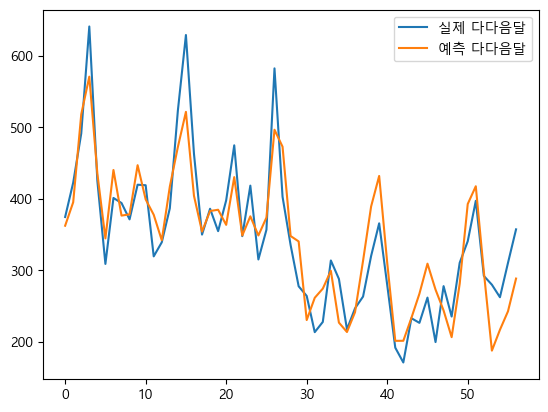

In [95]:
plt.plot(y)
plt.plot(reg3.predict(X))
plt.legend(['실제 다다음달', '예측 다다음달'])
plt.show()

In [96]:
import statsmodels.api as sm

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              saleNxmn3   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     15.00
Date:                Thu, 06 Jul 2023   Prob (F-statistic):           8.04e-12
Time:                        16:00:08   Log-Likelihood:                -297.72
No. Observations:                  57   AIC:                             621.4
Df Residuals:                      44   BIC:                             648.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              101.4185    187.360  

In [97]:
# 변수들간의 상관관계를 구한 후
# 조합별로 표시하도록 unstack
corrTbl = dfnxmn3Sfcst[feats3 + ['saleNxmn3']].corr().unstack().reset_index()

# 자기자신과 상관관계나 절대값이 작은 조합은 제외
corrTbl[(corrTbl[0].abs()>0.6) & (corrTbl[0].abs()<1)].sort_values(0)

# 상관관계가 강한 변수 조합들이 많음 ( 다중공선성 존재)

,level_0,level_1,0
10,saleSeries,yrSeq_nxmn3,-0.631771
130,yrSeq_nxmn3,saleSeries,-0.631771
137,yrSeq_nxmn3,uniqlo,-0.627105
101,uniqlo,yrSeq_nxmn3,-0.627105
96,uniqlo,coronaCummean,-0.619023
72,coronaCummean,uniqlo,-0.619023
5,saleSeries,coronaCummean,-0.606833
65,coronaCummean,saleSeries,-0.606833
142,yrSeq_nxmn3,saleNxmn3,-0.603084
166,saleNxmn3,yrSeq_nxmn3,-0.603084


### 예측값 산출용 테이블 준비

In [98]:
df2predict = sales05[['yrmon', 'monSeq', 'yrSeq']]
df2predict.tail()

,yrmon,monSeq,yrSeq
55,2021-12,11,4
56,2022-01,0,4
57,2022-02,1,4
58,2022-03,2,5
59,2022-04,3,5


In [99]:
df2predF = pd.DataFrame([['2022-05',4,5], ['2022-06',5,5], ['2022-07',6,5]])
df2predF.columns = df2predict.columns
df2predF

,yrmon,monSeq,yrSeq
0,2022-05,4,5
1,2022-06,5,5
2,2022-07,6,5


In [100]:
df2predict = pd.concat([df2predict,df2predF])
df2predict.reset_index(drop=True, inplace=True)
df2predict.tail()

,yrmon,monSeq,yrSeq
58,2022-03,2,5
59,2022-04,3,5
60,2022-05,4,5
61,2022-06,5,5
62,2022-07,6,5


In [101]:
df2predict['mon'] = df2predict['yrmon'].str.slice(5,7)

df2predict = df2predict.merge(sales04m[['mon', 'meanMonAmt']], how='left', on='mon')
df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt
58,2022-03,2,5,03,0.618468
59,2022-04,3,5,04,0.649167
60,2022-05,4,5,05,0.760362
61,2022-06,5,5,06,0.647433
62,2022-07,6,5,07,0.643221


In [102]:
# 다음 행의 같은 컬럼 값을 컬럼으로 추가

df2predict['monSeq_nxmn'] = df2predict['monSeq'].shift(-1)
df2predict['monSeq_nxmn2'] = df2predict['monSeq'].shift(-2)
df2predict['monSeq_nxmn3'] = df2predict['monSeq'].shift(-3)
df2predict['yrSeq_nxmn'] = df2predict['yrSeq'].shift(-1)
df2predict['yrSeq_nxmn2'] = df2predict['yrSeq'].shift(-2)
df2predict['yrSeq_nxmn3'] = df2predict['yrSeq'].shift(-3)
df2predict['meanMonAmt_nxmn'] = df2predict['meanMonAmt'].shift(-1)
df2predict['meanMonAmt_nxmn2'] = df2predict['meanMonAmt'].shift(-2)
df2predict['meanMonAmt_nxmn3'] = df2predict['meanMonAmt'].shift(-3)

df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt,monSeq_nxmn,monSeq_nxmn2,monSeq_nxmn3,yrSeq_nxmn,yrSeq_nxmn2,yrSeq_nxmn3,meanMonAmt_nxmn,meanMonAmt_nxmn2,meanMonAmt_nxmn3
58,2022-03,2,5,03,0.618468,3.0,4.0,5.0,5.0,5.0,5.0,0.649167,0.760362,0.647433
59,2022-04,3,5,04,0.649167,4.0,5.0,6.0,5.0,5.0,5.0,0.760362,0.647433,0.643221
60,2022-05,4,5,05,0.760362,5.0,6.0,NaN,5.0,5.0,NaN,0.647433,0.643221,NaN
61,2022-06,5,5,06,0.647433,6.0,NaN,NaN,5.0,NaN,NaN,0.643221,NaN,NaN
62,2022-07,6,5,07,0.643221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df2predict = df2predict.merge(sales05[['yrmon', 'saleSeries', 'corona', 'coronaCummean', 'musinsa', 'uniqlo', 'kakaoStyle']], how='left', on='yrmon')
df2predict.tail()

,yrmon,monSeq,yrSeq,mon,meanMonAmt,monSeq_nxmn,monSeq_nxmn2,monSeq_nxmn3,yrSeq_nxmn,yrSeq_nxmn2,yrSeq_nxmn3,meanMonAmt_nxmn,meanMonAmt_nxmn2,meanMonAmt_nxmn3,saleSeries,corona,coronaCummean,musinsa,uniqlo,kakaoStyle
58,2022-03,2,5,03,0.618468,3.0,4.0,5.0,5.0,5.0,5.0,0.649167,0.760362,0.647433,310.564325,25.75,10.422881,53.0,15.0,54.5
59,2022-04,3,5,04,0.649167,4.0,5.0,6.0,5.0,5.0,5.0,0.760362,0.647433,0.643221,357.360528,16.00,10.515833,58.5,20.0,54.5
60,2022-05,4,5,05,0.760362,5.0,6.0,NaN,5.0,5.0,NaN,0.647433,0.643221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2022-06,5,5,06,0.647433,6.0,NaN,NaN,5.0,NaN,NaN,0.643221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2022-07,6,5,07,0.643221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
feats = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn', 'yrSeq_nxmn', 'meanMonAmt_nxmn']
# 다음달 값 예측치 산출
# 예측 대상 시점별로 각각의 모델이 사용할 변수만 투입
pred_nxmn = reg1.predict(df2predict.tail(4).head(1)[feats])[0]
print(pred_nxmn)

feats2 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn2', 'yrSeq_nxmn2', 'meanMonAmt_nxmn2']
# 다다음달 값 예측치 산출
pred_nxmn2 = reg2.predict(df2predict.tail(4).head(1)[feats])[0] 
print(pred_nxmn2)

feats3 = ['saleSeries','monSeq','yrSeq', 'meanMonAmt','corona','coronaCummean','musinsa','uniqlo', 'kakaoStyle', 'monSeq_nxmn3', 'yrSeq_nxmn3', 'meanMonAmt_nxmn3']
# 다다음달 값 예측치 산출
pred_nxmn3 = reg3.predict(df2predict.tail(4).head(1)[feats])[0] 
print(pred_nxmn3)

347.561268926682


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- meanMonAmt_nxmn
- monSeq_nxmn
- yrSeq_nxmn
Feature names seen at fit time, yet now missing:
- meanMonAmt_nxmn2
- monSeq_nxmn2
- yrSeq_nxmn2


In [ ]:
plt.figure(figsize=(12,4))
colors1 = np.append(np.repeat('grey',60), np.repeat('red',3))
sales_n_fcst = np.append(df2predict.head(60).saleSeries, [pred_nxmn, pred_nxmn2, pred_nxmn3])
df2predict.saleSeries = sales_n_fcst
plt.bar(df2predict.yrmon, df2predict.saleSeries,
        color=colors1)
plt.xticks(rotation=90)
plt.title('실제 및 예측 매출 추이')
plt.axhline(df2predict.saleSeries.head(60).mean(), color='black', linestyle=':')
plt.show()

In [ ]:
dfpred2pivot = df2predict[['yrmon','monSeq', 'saleSeries']]
dfpred2pivot['year'] = dfpred2pivot.yrmon.str.slice(0,4)

dfpred_pivot = dfpred2pivot.pivot(index='monSeq', columns='year', values='saleSeries').reset_index()
dfpred_pivot.columns = dfpred_pivot.columns.astype(str)
dfpred_pivot

In [ ]:
colorKeys = np.arange(2,8)/6
i=0
for x in dfpred_pivot.columns[1:]: 
    # 최근 년도일수록 밝은 색으로 구별
    colors1 = [0,0,colorKeys[i]]
    if i==5:
        # 최근 년도만 red로 강조
        colors1 = 'red'
    plt.plot(dfpred_pivot.monSeq+1, dfpred_pivot[x],
             marker='o',
             color=colors1)
    i+=1
plt.legend(dfpred_pivot.columns[1:])
plt.xlabel('월')
plt.title('실제 및 예측 매출 추이')
plt.axvline(4.5, linestyle=':', alpha=0.5, color='grey')

# 각 컬럼별 최대값 중에 최대값을 구해 범위 설정
plt.ylim(0,dfpred_pivot[dfpred_pivot.columns[1:]].max().max()*1.05)
plt.show()

## Section 5 : 외부환경요인의 매출영향도 분석

In [ ]:
sales05.tail(3)

#### 매출을 설명하는 모델 생성

In [ ]:
from sklearn.linear_model import LinearRegression

# 판매금액계절지수 추가 변수를 포함해서  당월 매출을 추정하는 모델 생성
# 코로나 자체의 강도를 나타내는 외부 데이터 추가 필요
# 단, 계절적 판매지수 meanMonAmt 에는 코로나에 의한 영향이 반영되어 있어
# 얼마간 왜곡 존재 


feats = ['monSeq','yrSeq', 'meanMonAmt', 'corona','coronaCummean']
X = sales05[feats]
y = sales05.saleSeries
reg = LinearRegression().fit(X, y)

reg.score(X, y) # 결정계수 R2

In [ ]:
sales05[feats + ['saleSeries']].corr()

In [ ]:
sales05[feats + ['saleSeries']].corr()[['saleSeries']].sort_values('saleSeries').plot(kind='bar')
plt.ylabel('correlation')
plt.show()

In [ ]:
# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X), y, alpha=0.5)
plt.xlabel('모델 추정치')
plt.ylabel('실제 판매액')
plt.show()

np.corrcoef(reg.predict(X), y)[0,1]

In [ ]:
# 코로나가 전혀 없었을 경우의 값을 추정

sales05base = sales05.copy()
# 코로나 지수값을 0으로 변경
sales05base['corona'] = 0
# 코로가 없다고 가정하면 누적 값도 0
sales05base['coronaCummean'] = 0
X1 = sales05base[feats]
display( sales05base.tail())

# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X1), y, alpha=0.5)
plt.xlabel('코로나 없는 경우에 대한 모델 추정치')
plt.ylabel('실제 판매액')
plt.show()

In [ ]:
plt.plot(np.arange(len(X)), reg.predict(X), alpha=0.8, color='green')
plt.scatter(np.arange(len(X)), y, s=10, alpha=0.5)
plt.ylabel('판매액')
plt.legend(['모델추정치', '실제값'])
plt.ylim(0, max(y)*1.1)
plt.show()

In [ ]:
# 과거기간의 실제 판매와 모델이 추정한 값 간의 관계
plt.scatter(reg.predict(X), reg.predict(X1), alpha=0.5)
plt.xlabel('실제 판매액에 대한 모델 추정치')
plt.ylabel('코로나 없는 경우에 대한 모델 추정치')
plt.show()

In [ ]:
# 추정한 정상수준(baseline)과 실제값 간의 차이 영역에 색칠

fig, ax = plt.subplots()
ax.fill_between(np.arange(len(X1)), reg.predict(X), reg.predict(X1), 
                alpha=0.2, color='grey')
plt.plot(reg.predict(X), alpha=0.8)
plt.plot(reg.predict(X1), alpha=0.8)
plt.legend(['실제값', '추정 정상값'])
plt.axhline(reg.predict(X1).max(), color='grey', linestyle=':')
plt.axhline(reg.predict(X1).min(), color='grey', linestyle=':')
plt.ylim(0,reg.predict(X1).max()*1.1)

# 코로나가 없었을 경우에 대한 추정치의 추세 보조선
varx = np.arange(len(X1))
vary = reg.predict(X1)
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=5, alpha=0.5)

plt.show()

In [ ]:
dfimpact = sales05base[['yrmon', 'saleSeries']]
dfimpact['predAmt'] = reg.predict(X)
dfimpact['predAmt_noCorona'] = reg.predict(X1)
dfimpact['impactAmt'] = dfimpact.predAmt - dfimpact.predAmt_noCorona
dfimpact.tail()

In [ ]:
dfimpact1 = dfimpact[dfimpact.impactAmt< -10]
dfimpact1.tail()

In [ ]:
impactValue = dfimpact1.impactAmt.sum() / dfimpact1.predAmt_noCorona.sum() * 100

plt.bar(['정상수준', '코로나영향(실제)'], [100, 100+impactValue],
       color=['green', 'grey'], alpha=0.5, width=0.5)
plt.title('코로나 기간 매출감소 영향 규모')

# 소수점 한자리, 문자열 형식으로 변경, 뒤에 '%' 표시 붙임
text2show = str(round(impactValue,1)) + '%'
plt.text(1, 85, text2show, 
         # 좌표에 가운데 정렬
         ha='center', 
         size=30, color='red', 
         # 텍스트를 bold로 두껍게 표시
         weight='bold')
plt.show()

# 추정 정상수준 대비 28% 가량의 판매가 코로나로 인해 사라졌음을 확인